# Initial tinkering with E. coli iModulon data to see if we can train a CNN to learn M-matrix values

In [1]:
import pandas as pd
import numpy as np
import utils as u
import matplotlib.pyplot as plt
import matplotlib
import scipy.stats


import altair as alt
import seaborn as sns
import torch_utils as tu

import torch

In [2]:
import utils as u 
import torch_utils as tu
import models as m

from sklearn.metrics import r2_score

from skorch import NeuralNetRegressor
from skorch.callbacks import EarlyStopping,Checkpoint,GradientNormClipping
from skorch.dataset import Dataset
from skorch.helper import predefined_split


## Load data

In [3]:
fname = 'ec_iMod_out/ecoli_seq_M_opFilt.tsv' 
XY = pd.read_csv(fname,sep='\t')

display(XY.head())

loc2seq = dict([(x,z) for (x,z) in XY[['locus_tag','upstream_region']].values])

print(loc2seq['b3575'])

,locus_tag,gene,product,type,strand,start,upstream_region,0,1,2,...,82,83,84,85,86,87,88,89,90,91
0,b0005,yaaX,DUF2502 domain-containing protein YaaX,CDS,1,5233,GGCAGAACGTGCTGATTTACCCTTGCTTTCACATAATCTGCCCGCC...,0.008229,-0.000685,-0.005215,...,-0.006856,0.010676,0.008874,0.018497,0.000700,-0.013267,0.015265,0.016886,-0.015319,-0.020727
1,b0007,yaaJ,putative transporter YaaJ,CDS,-1,6528,AGGGAGGTCAATTTGTCCGTCATGATAGTATTTCTCTTTAAACAGC...,0.008111,-0.003929,0.003207,...,-0.000337,-0.010468,0.016122,0.010361,-0.003899,-0.022839,-0.003665,-0.001823,-0.023604,-0.012765
2,b0008,talB,transaldolase B,CDS,1,8237,ATGAAGGAGAAAAAATCTGGCATGCATATCCCTCTTATTGCCGGTC...,0.008629,-0.001270,-0.005664,...,0.000394,0.007215,-0.000707,-0.012959,-0.002329,0.006391,-0.003650,-0.008537,0.002898,-0.000891
3,b0009,mog,molybdopterin adenylyltransferase,CDS,1,9305,AGGGGCTATCGAACGTAAACTGTCTTACACCGGCGAAGTGAAAGCG...,0.002952,0.002053,-0.002882,...,-0.009291,-0.000226,0.016013,0.002179,0.004891,-0.002365,-0.003490,-0.006066,-0.011982,0.011477
4,b0010,satP,acetate/succinate:H(+) symporter,CDS,-1,9927,CATGGTTTGCTGCGCGGCGCGGGGCTGGGAGGCCCTGTAGGTGCGG...,0.006142,0.000884,0.008166,...,-0.009214,-0.010588,0.001363,0.003979,-0.005208,0.003190,-0.015137,-0.005784,-0.001302,0.010800


TCAATCAGCATCAACCCGCGAAACAGACTCTGGCTTCCGGCTGGACGCTCTTTTTCCTGCGCCATCTCGTTCTCTTTTTTTCCCATCACTTCTTTCCCCATTTTGTCGCGTCCTGATGGTAGCGCAAAGTGTGCCGTAGTTCACGATCTCGACAGATAATTTATAACCAATTGATTTTTATGTCTTTTGAAATTCATCAATCAGATTGCCTTGTTAAAAAGTGATCGATATATTTGAAATCAAGTTTCGCATATTGAAATTTTAAGCCAAAAAAGCGATCAAAAAAACAAGGAAGCCTGG


In [4]:
def view_train_test_dist(train_df,test_df,score_cols,title,val_df=None):
    train_df['set'] = 'train'
    test_df['set'] = 'test'
    if val_df is not None:
        val_df['set'] = "val"
        df = pd.concat([train_df,test_df,val_df])
    else:
        df = pd.concat([train_df,test_df])
    
    df_melt = pd.melt(df, id_vars=['locus_tag','set'],value_vars=score_cols,var_name='cond',value_name='tpm_lr')
    
    sns.stripplot(data=df_melt,x='cond',y='tpm_lr',hue='set',dodge=True,alpha=0.2)
    plt.title(f"{title} distribution")
    plt.show()

(1703, 100)
(426, 100)
(1362, 101)
(341, 101)


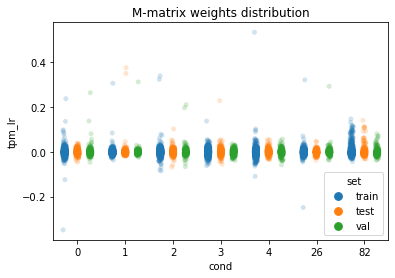

In [5]:
# Split data into train/test/split here and now
full_train_df,test_df = tu.quick_split(XY)
train_df, val_df = tu.quick_split(full_train_df)

print(full_train_df.shape)
print(test_df.shape)
print(train_df.shape)
print(val_df.shape)


coi = ['0','1','2','3','4','26','82']
assert(train_df.shape[0] + val_df.shape[0] == full_train_df.shape[0])
view_train_test_dist(train_df, test_df,coi,"M-matrix weights",val_df=val_df)

## convert to skorch-able dfs

In [6]:
# get iModulon column labels
M = pd.read_csv('ec_iMod_out/iMod_download/M.csv',index_col=0)
imods = M.columns
imods[:5]

Index(['0', '1', '2', '3', '4'], dtype='object')

In [7]:
def make_mt_skorch_dfs(df,seq_col='seq',target_cols=['highCu','noCu']):
    '''
    Make multi-task X,y matrix,vec for skorch fit() loop.
    '''
    seqs = list(df[seq_col].values)        
    ohe_seqs = torch.stack([torch.tensor(u.one_hot_encode(x)) for x in seqs])

    # number of labels = len(target_cols)
    labels = torch.tensor(list(df[target_cols].values))
    # bad dimension? fixed in model.forward for now
    
    return ohe_seqs.float(), labels.float()

In [ ]:
# X, y = make_mt_skorch_dfs(XY, seq_col="upstream_region",target_cols=imods)
# print("\nX:",X.shape)
# print("y:",y.shape)

# Xtrain, ytrain = make_mt_skorch_dfs(train_df, seq_col="upstream_region",target_cols=imods)
# print("\nXtrain:",Xtrain.shape)
# print("ytrain:",ytrain.shape)

# Xval, yval = make_mt_skorch_dfs(val_df, seq_col="upstream_region",target_cols=imods)
# print("\nXval:",Xval.shape)
# print("yval:",yval.shape)

# Xtest, ytest = make_mt_skorch_dfs(test_df, seq_col="upstream_region",target_cols=imods)
# print("\nXtest:",Xtest.shape)
# print("ytest:",ytest.shape)

# Xfull_train, yfull_train = make_mt_skorch_dfs(full_train_df, seq_col="upstream_region",target_cols=imods)
# print("\nXfull_train:",Xfull_train.shape)
# print("yfull_train:",yfull_train.shape)

In [9]:
X, y = make_mt_skorch_dfs(XY, seq_col="upstream_region",target_cols=coi)
print("\nX:",X.shape)
print("y:",y.shape)

Xtrain, ytrain = make_mt_skorch_dfs(train_df, seq_col="upstream_region",target_cols=coi)
print("\nXtrain:",Xtrain.shape)
print("ytrain:",ytrain.shape)

Xval, yval = make_mt_skorch_dfs(val_df, seq_col="upstream_region",target_cols=coi)
print("\nXval:",Xval.shape)
print("yval:",yval.shape)

Xtest, ytest = make_mt_skorch_dfs(test_df, seq_col="upstream_region",target_cols=coi)
print("\nXtest:",Xtest.shape)
print("ytest:",ytest.shape)

Xfull_train, yfull_train = make_mt_skorch_dfs(full_train_df, seq_col="upstream_region",target_cols=coi)
print("\nXfull_train:",Xfull_train.shape)
print("yfull_train:",yfull_train.shape)


X: torch.Size([2129, 300, 4])
y: torch.Size([2129, 7])

Xtrain: torch.Size([1362, 300, 4])
ytrain: torch.Size([1362, 7])

Xval: torch.Size([341, 300, 4])
yval: torch.Size([341, 7])

Xtest: torch.Size([426, 300, 4])
ytest: torch.Size([426, 7])

Xfull_train: torch.Size([1703, 300, 4])
yfull_train: torch.Size([1703, 7])


In [10]:
# make skorch predefined valid ds
#valid_ds = Dataset(Xval, yval)

## pick some params

In [11]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

In [12]:
# just pick some
# Adam, 32 filt, fast LR
# net_regr1 = NeuralNetRegressor(
#     m.DNA_2CNN_Multi, # my pytorch model
#     module__seq_len=300, # pass arg to pytorch model
#     module__n_tasks=ytrain.shape[1],
#     module__num_filters1=64,
#     module__num_filters2=64,
#     module__kernel_size1=12,
#     module__kernel_size2=6,
#     module__conv_pool_size1=3, 
#     module__conv_pool_size2=1,
#     module__fc_node_num1 = 100,
#     module__fc_node_num2 = 10,
#     module__dropout1 = 0.2,
#     module__dropout2 = 0.2,
#     max_epochs=2000,
#     lr=0.01,
#     device=DEVICE,  # uncomment this to train with CUDA
#      callbacks=[
#          EarlyStopping(patience=500),
#          Checkpoint(load_best=True),
#          GradientNormClipping()
#      ],
#     optimizer=torch.optim.SGD,
#     iterator_train__shuffle=True,
#     #train_split=predefined_split(valid_ds)
#     #train_split=None
# )

net_regr1 = NeuralNetRegressor(
    m.DNA_2CNN_2FC_Multi, # my pytorch model
    module__seq_len=300, # pass arg to pytorch model
    module__n_tasks=ytrain.shape[1],
    module__num_filters1=128,
    module__num_filters2=64,
    module__kernel_size1=8,
    module__kernel_size2=8,
    module__conv_pool_size1=3, 
    module__conv_pool_size2=1,
    module__fc_node_num1 = 100,
    module__fc_node_num2 = 100,
    module__dropout1 = 0.2,
    module__dropout2 = 0.2,
    max_epochs=2000,
    lr=0.01,
    device=DEVICE,  # uncomment this to train with CUDA
     callbacks=[
         EarlyStopping(patience=500),
         Checkpoint(load_best=True),
         GradientNormClipping()
     ],
    optimizer=torch.optim.SGD,
    iterator_train__shuffle=True,
    #train_split=predefined_split(valid_ds)
    #train_split=None
)


In [13]:
net_regr1.fit(Xfull_train, yfull_train)


  epoch    train_loss    valid_loss    cp     dur
-------  ------------  ------------  ----  ------
      1        0.0065        0.0057     +  3.0231
      2        0.0057        0.0049     +  0.1058
      3        0.0050        0.0043     +  0.0864
      4        0.0044        0.0038     +  0.0844
      5        0.0039        0.0033     +  0.0745
      6        0.0034        0.0030     +  0.0744
      7        0.0031        0.0026     +  0.0746
      8        0.0028        0.0024     +  0.0752
      9        0.0025        0.0021     +  0.0743
     10        0.0022        0.0019     +  0.0738
     11        0.0020        0.0017     +  0.0749
     12        0.0018        0.0015     +  0.0735
     13        0.0017        0.0014     +  0.0747
     14        0.0015        0.0012     +  0.0748
     15        0.0014        0.0011     +  0.0731
     16        0.0013        0.0010     +  0.0749
     17        0.0012        0.0009     +  0.0744
     18        0.0011        0.0008     +  0.0737


    133        0.0004        0.0002     +  0.0740
    134        0.0004        0.0002     +  0.0747
    135        0.0004        0.0002     +  0.0755
    136        0.0003        0.0002        0.0747
    137        0.0004        0.0002     +  0.0739
    138        0.0003        0.0002     +  0.0749
    139        0.0003        0.0002     +  0.0752
    140        0.0003        0.0002        0.0745
    141        0.0003        0.0002     +  0.0751
    142        0.0004        0.0002     +  0.0749
    143        0.0004        0.0002     +  0.0744
    144        0.0003        0.0002     +  0.0743
    145        0.0004        0.0002     +  0.0759
    146        0.0003        0.0002     +  0.0747
    147        0.0003        0.0002     +  0.0742
    148        0.0004        0.0002     +  0.0738
    149        0.0004        0.0002     +  0.0743
    150        0.0003        0.0002     +  0.0745
    151        0.0004        0.0002     +  0.0746
    152        0.0003        0.0002     +  0.0733


    274        0.0003        0.0002     +  0.0738
    275        0.0003        0.0002     +  0.0745
    276        0.0003        0.0002     +  0.0750
    277        0.0003        0.0002     +  0.0746
    278        0.0003        0.0002     +  0.0738
    279        0.0003        0.0002     +  0.0735
    280        0.0003        0.0002     +  0.0740
    281        0.0003        0.0002     +  0.0753
    282        0.0003        0.0002     +  0.0756
    283        0.0003        0.0002     +  0.0743
    284        0.0003        0.0002     +  0.0745
    285        0.0003        0.0002        0.0750
    286        0.0003        0.0002     +  0.0734
    287        0.0003        0.0002     +  0.0759
    288        0.0003        0.0002     +  0.0760
    289        0.0003        0.0002     +  0.0750
    290        0.0003        0.0002        0.0743
    291        0.0003        0.0002     +  0.0745
    292        0.0003        0.0002     +  0.0747
    293        0.0003        0.0002     +  0.0746


    417        0.0003        0.0002     +  0.0737
    418        0.0003        0.0002     +  0.0742
    419        0.0003        0.0002     +  0.0747
    420        0.0003        0.0002     +  0.0750
    421        0.0003        0.0002        0.0753
    422        0.0003        0.0002     +  0.0746
    423        0.0003        0.0002        0.0753
    424        0.0003        0.0002        0.0731
    425        0.0003        0.0002     +  0.0749
    426        0.0003        0.0002     +  0.0760
    427        0.0003        0.0002        0.0752
    428        0.0003        0.0002        0.0734
    429        0.0003        0.0002     +  0.0745
    430        0.0003        0.0002     +  0.0751
    431        0.0003        0.0002     +  0.0747
    432        0.0003        0.0002     +  0.0751
    433        0.0003        0.0002     +  0.0747
    434        0.0003        0.0002     +  0.0749
    435        0.0003        0.0002     +  0.0747
    436        0.0003        0.0002     +  0.0750


    561        0.0003        0.0002        0.0748
    562        0.0003        0.0002     +  0.0736
    563        0.0003        0.0002     +  0.0749
    564        0.0003        0.0002     +  0.0747
    565        0.0003        0.0002     +  0.0753
    566        0.0003        0.0002        0.0754
    567        0.0003        0.0002     +  0.0731
    568        0.0003        0.0002     +  0.0745
    569        0.0003        0.0002     +  0.0753
    570        0.0003        0.0002     +  0.0752
    571        0.0003        0.0002     +  0.0758
    572        0.0003        0.0002     +  0.0756
    573        0.0003        0.0002     +  0.0756
    574        0.0003        0.0002     +  0.0747
    575        0.0003        0.0002     +  0.0737
    576        0.0003        0.0002     +  0.0738
    577        0.0003        0.0002     +  0.0746
    578        0.0003        0.0002     +  0.0749
    579        0.0003        0.0002     +  0.0741
    580        0.0003        0.0002     +  0.0748


    709        0.0003        0.0002     +  0.0754
    710        0.0003        0.0002     +  0.0747
    711        0.0003        0.0002     +  0.0752
    712        0.0003        0.0002     +  0.0752
    713        0.0003        0.0002     +  0.0747
    714        0.0003        0.0002        0.0746
    715        0.0003        0.0002     +  0.0754
    716        0.0003        0.0002     +  0.0751
    717        0.0003        0.0002        0.0759
    718        0.0003        0.0002        0.0746
    719        0.0003        0.0002     +  0.0742
    720        0.0003        0.0002     +  0.0754
    721        0.0003        0.0002     +  0.0751
    722        0.0003        0.0002        0.0760
    723        0.0003        0.0002        0.0738
    724        0.0003        0.0002        0.0750
    725        0.0003        0.0002        0.0732
    726        0.0003        0.0002        0.0746
    727        0.0003        0.0002        0.0749
    728        0.0003        0.0002        0.0737


    862        0.0003        0.0002        0.0745
    863        0.0003        0.0002     +  0.0733
    864        0.0003        0.0002        0.0740
    865        0.0003        0.0002     +  0.0731
    866        0.0003        0.0002        0.0753
    867        0.0003        0.0002        0.0745
    868        0.0003        0.0002        0.0736
    869        0.0003        0.0002        0.0735
    870        0.0003        0.0002        0.0743
    871        0.0003        0.0002        0.0739
    872        0.0003        0.0002        0.0742
    873        0.0003        0.0002        0.0737
    874        0.0003        0.0002        0.0747
    875        0.0003        0.0002        0.0746
    876        0.0003        0.0002        0.0739
    877        0.0003        0.0002        0.0743
    878        0.0003        0.0002     +  0.0739
    879        0.0003        0.0002        0.0753
    880        0.0003        0.0002        0.0745
    881        0.0003        0.0002        0.0742


   1020        0.0003        0.0002        0.0750
   1021        0.0003        0.0002        0.0738
   1022        0.0003        0.0002     +  0.0750
   1023        0.0003        0.0002     +  0.0746
   1024        0.0003        0.0002     +  0.0757
   1025        0.0003        0.0002        0.0749
   1026        0.0003        0.0002        0.0737
   1027        0.0003        0.0002     +  0.0749
   1028        0.0003        0.0002        0.0750
   1029        0.0003        0.0002     +  0.0752
   1030        0.0003        0.0002     +  0.0764
   1031        0.0003        0.0002     +  0.0748
   1032        0.0003        0.0002     +  0.0758
   1033        0.0003        0.0002        0.0757
   1034        0.0003        0.0002        0.0746
   1035        0.0003        0.0002        0.0745
   1036        0.0003        0.0002        0.0740
   1037        0.0003        0.0002        0.0749
   1038        0.0003        0.0002        0.0735
   1039        0.0003        0.0002        0.0732


   1176        0.0003        0.0002        0.0752
   1177        0.0003        0.0002        0.0750
   1178        0.0003        0.0002     +  0.0763
   1179        0.0003        0.0002        0.0767
   1180        0.0003        0.0002        0.0753
   1181        0.0003        0.0002        0.0739
   1182        0.0003        0.0002     +  0.0751
   1183        0.0003        0.0002     +  0.0752
   1184        0.0003        0.0002     +  0.0770
   1185        0.0003        0.0002     +  0.0754
   1186        0.0003        0.0002     +  0.0766
   1187        0.0003        0.0002     +  0.0761
   1188        0.0003        0.0002     +  0.0749
   1189        0.0003        0.0002     +  0.0765
   1190        0.0003        0.0002     +  0.0746
   1191        0.0003        0.0002        0.0832
   1192        0.0003        0.0002        0.0834
   1193        0.0003        0.0002        0.0791
   1194        0.0003        0.0002     +  0.0757
   1195        0.0003        0.0002     +  0.0769


   1331        0.0003        0.0002        0.0751
   1332        0.0003        0.0002     +  0.0745
   1333        0.0003        0.0002        0.0757
   1334        0.0003        0.0002        0.0747
   1335        0.0003        0.0002     +  0.0748
   1336        0.0003        0.0002        0.0759
   1337        0.0003        0.0002     +  0.0753
   1338        0.0003        0.0002     +  0.0768
   1339        0.0003        0.0002     +  0.0756
   1340        0.0003        0.0002     +  0.0770
   1341        0.0003        0.0002     +  0.0766
   1342        0.0003        0.0002     +  0.0753
   1343        0.0003        0.0002        0.0767
   1344        0.0003        0.0002     +  0.0752
   1345        0.0003        0.0002        0.0765
   1346        0.0003        0.0002        0.0779
   1347        0.0003        0.0002     +  0.0761
   1348        0.0003        0.0002        0.0756
   1349        0.0003        0.0002        0.0754
   1350        0.0003        0.0002        0.0738


   1487        0.0003        0.0002        0.0750
   1488        0.0003        0.0002        0.0738
   1489        0.0003        0.0002        0.0748
   1490        0.0003        0.0002        0.0734
   1491        0.0003        0.0002        0.0750
   1492        0.0003        0.0002        0.0746
   1493        0.0003        0.0002        0.0740
   1494        0.0003        0.0002        0.0760
   1495        0.0003        0.0002        0.0739
   1496        0.0003        0.0002     +  0.0764
   1497        0.0003        0.0002        0.0774
   1498        0.0003        0.0002        0.0743
   1499        0.0003        0.0002        0.0754
   1500        0.0003        0.0002        0.0756
   1501        0.0003        0.0002        0.0736
   1502        0.0003        0.0002        0.0751
   1503        0.0003        0.0002     +  0.0745
   1504        0.0003        0.0002     +  0.0761
   1505        0.0003        0.0002        0.0769
   1506        0.0003        0.0002        0.0750


   1644        0.0003        0.0002     +  0.0762
   1645        0.0003        0.0002     +  0.0754
   1646        0.0003        0.0002     +  0.0752
   1647        0.0003        0.0002        0.0756
   1648        0.0003        0.0002        0.0763
   1649        0.0003        0.0002        0.0750
   1650        0.0003        0.0002        0.0777
   1651        0.0003        0.0002        0.0762
   1652        0.0003        0.0002     +  0.0741
   1653        0.0003        0.0002        0.0753
   1654        0.0003        0.0002        0.0762
   1655        0.0003        0.0002        0.0750
   1656        0.0003        0.0002        0.0746
   1657        0.0003        0.0002        0.0751
   1658        0.0003        0.0002        0.0748
   1659        0.0003        0.0002        0.0756
   1660        0.0003        0.0002        0.0752
   1661        0.0003        0.0002        0.0746
   1662        0.0003        0.0002        0.0763
   1663        0.0003        0.0002        0.0736


   1802        0.0003        0.0002        0.0758
   1803        0.0003        0.0002        0.0742
   1804        0.0003        0.0002        0.0761
   1805        0.0003        0.0002        0.0757
   1806        0.0003        0.0002        0.0741
   1807        0.0003        0.0002        0.0754
   1808        0.0003        0.0002        0.0739
   1809        0.0003        0.0002        0.0763
   1810        0.0003        0.0002        0.0748
   1811        0.0003        0.0002     +  0.0761
   1812        0.0003        0.0002     +  0.0752
   1813        0.0003        0.0002     +  0.0748
   1814        0.0003        0.0002        0.0756
   1815        0.0003        0.0002        0.0759
   1816        0.0003        0.0002        0.0759
   1817        0.0003        0.0002        0.0747
   1818        0.0003        0.0002     +  0.0760
   1819        0.0003        0.0002     +  0.0774
   1820        0.0003        0.0002        0.0781
   1821        0.0003        0.0002        0.0747


   1963        0.0003        0.0002        0.0754
   1964        0.0003        0.0002        0.0758
   1965        0.0003        0.0002        0.0747
   1966        0.0003        0.0002        0.0757
   1967        0.0003        0.0002        0.0741
   1968        0.0003        0.0002        0.0756
   1969        0.0003        0.0002     +  0.0749
   1970        0.0003        0.0002     +  0.0753
   1971        0.0003        0.0002        0.0752
   1972        0.0003        0.0002     +  0.0744
   1973        0.0003        0.0002     +  0.0752
   1974        0.0003        0.0002     +  0.0769
   1975        0.0003        0.0002     +  0.0764
   1976        0.0003        0.0002        0.0757
   1977        0.0003        0.0002     +  0.0844
   1978        0.0003        0.0002        0.0862
   1979        0.0003        0.0002        0.0872
   1980        0.0003        0.0002        0.0875
   1981        0.0003        0.0002     +  0.0826
   1982        0.0003        0.0002        0.0779


<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=DNA_2CNN_2FC_Multi(
    (conv_net): Sequential(
      (0): Conv2d(1, 128, kernel_size=(4, 8), stride=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=(1, 3), stride=(1, 3), padding=0, dilation=1, ceil_mode=False)
      (3): Dropout(p=0.2, inplace=False)
      (4): Conv2d(128, 64, kernel_size=(1, 8), stride=(1, 1))
      (5): ReLU()
      (6): Dropout(p=0.2, inplace=False)
      (7): Flatten()
      (8): Linear(in_features=5760, out_features=100, bias=True)
      (9): ReLU()
      (10): Linear(in_features=100, out_features=100, bias=True)
      (11): ReLU()
      (12): Linear(in_features=100, out_features=7, bias=True)
    )
  ),
)

# Viz model results

In [14]:
def sk_loss_plot(nets):
    fig = plt.figure(figsize=(20,10))
    for i,(net,name) in enumerate(nets):
        # plot net_regr's loss trace
        train_loss = net.history[:, 'train_loss']
        valid_loss = net.history[:, 'valid_loss']

#         plt.plot(train_loss, 'o-', label='training')
#         plt.plot(valid_loss, 'o-', label='validation')
        
        plt.plot(train_loss,'-',color=f"C{i}", label=f"{name} Train",linewidth=0.75,alpha=0.5)
        plt.plot(valid_loss,'-',color=f"C{i}", label=f"{name} Val",linewidth=3.0,alpha=0.5)
        
        val_min_ep,val_min = min(enumerate(valid_loss),key = lambda t: t[1])
        plt.axhline(val_min,linestyle='--',c=f"C{i}",linewidth=0.5)
        plt.axvline(val_min_ep,linestyle='--',c=f"C{i}",linewidth=0.5)
        #plt.axhline(5,c='k')

    plt.ylim(0,0.01)
    plt.xlabel("Epoch",fontsize=14)
    plt.ylabel("MSE Loss",fontsize=14)
    plt.legend(bbox_to_anchor=(1,1),loc='upper left')
    plt.show()
    
def parity_plot(title,ytrue,ypred, r2,rigid=False):
    plt.scatter(ytrue, ypred, alpha=0.2)
    
    # y=x line
    xpoints = ypoints = plt.xlim()
    if rigid:
        plt.ylim(min(xpoints),max(xpoints)) 
    plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=2, scalex=False, scaley=False)

    plt.xlabel("Actual Score",fontsize=14)
    plt.ylabel("Predicted Score",fontsize=14)
    #plt.title(f"{model_name} (pearson:{pearson:.3f})",fontsize=20)
    plt.title(f"{title} (r2:{r2:.3f})",fontsize=20)
    plt.show()

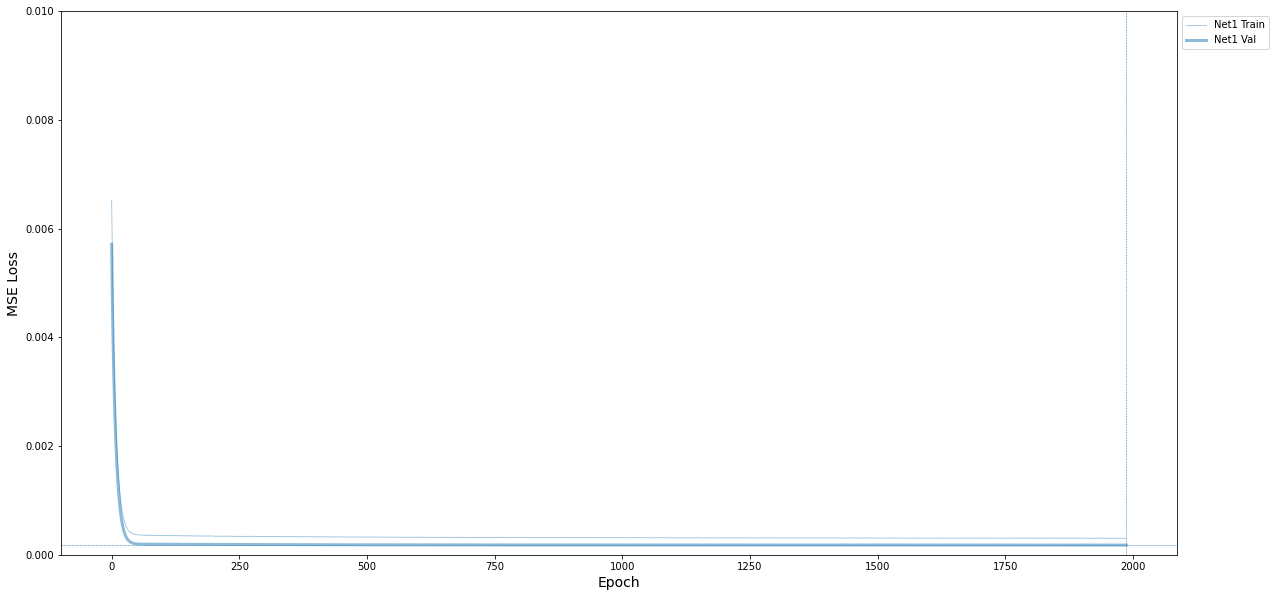

In [15]:
nets = [
    (net_regr1,'Net1'),
    #(net_regr_redo,'REDO')
]

sk_loss_plot(nets)

YTRUE torch.Size([1362, 7])
**** ave r2:     -0.016795381087558355
**** r2 overall: -0.016795382853936638
YTRUE torch.Size([341, 7])
**** ave r2:     -0.01895242381909428
**** r2 overall: -0.018952424091034353


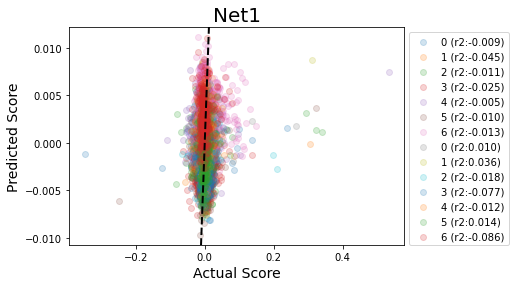

In [16]:
def parity_plot_comb(title,true_preds,rigid=False):
    all_net_r2s = []
    for (ytrue, ypred,name) in true_preds:
        print("YTRUE",ytrue.shape)
#         print("YPRED",ypred.shape)
        r2s = []
        for i in range(ytrue.shape[1]):
            ytruei = ytrue[:,i]
            ypredi = ypred[:,i]
            r2i = r2_score(ytruei,ypredi)
            #print(f"r2 {i}", r2i)
            r2s.append(r2i)
            plt.scatter(ytruei, ypredi, alpha=0.2,label=f"{i} (r2:{r2i:.3f})")
            
        r2 = r2_score(ytrue,ypred)
        r2i_mean = np.mean(r2s)
        print(f"**** ave r2:    ", r2i_mean)
        print(f"**** r2 overall:", r2)
        
        #plt.scatter(ytrue, ypred, alpha=0.2,label=f"{name} (r2:{r2:.3f})")
    
    # y=x line
    xpoints = ypoints = plt.xlim()
    if rigid:
        plt.ylim(min(xpoints),max(xpoints)) 
    plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=2, scalex=False, scaley=False)

    plt.xlabel("Actual Score",fontsize=14)
    plt.ylabel("Predicted Score",fontsize=14)
    #plt.title(f"{model_name} (pearson:{pearson:.3f})",fontsize=20)
    plt.title(f"{title}",fontsize=20)
    plt.legend(bbox_to_anchor=(1,1),loc='upper left')
    plt.show()

def view_preds(nets):
    # for each network to plot
    for (net,name) in nets:
        ytrain_pred = net.predict(Xtrain)
        yval_pred = net.predict(Xval)
        
#         print(ytrain_pred.shape)
#         print(yval_pred.shape)

        plot_list = [
            (ytrain,ytrain_pred,"train"),
            (yval,yval_pred,"val"),
        ]
        parity_plot_comb(name, plot_list)


#view_preds(nets[::-1])
view_preds(nets)

In [19]:
def view_multi_parity(title,ytrue,ypred,rigid=False, num_cols=8):
        
    num_plts = ytrue.shape[1]
    num_rows = int(np.ceil(num_plts/num_cols))
    
    max_point = max(max(ytrue.flatten()),max(ypred.flatten()))
    min_point = min(min(ytrue.flatten()),min(ypred.flatten()))
    
    plt.figure(figsize=(15, 5))
    

    for c in range(ytrue.shape[1]):
        
        # display raw filter
        ax1 = plt.subplot(num_rows, num_cols,c+1)
        yt = ytrue[:,c]
        yp = ypred[:,c]
        p = scipy.stats.pearsonr(yt,yp)[0]
        r2 = r2_score(yt,yp)
        
        ax1.scatter(yt,yp,color=f'C{c}',label=c,alpha=0.2)
        #ax1.set_title(f"{cond_dict[c]} (pearsonr:{p:.3f})")
        #ax1.set_title(f"{cond_dict[c]} (p:{p:.3f})")
        ax1.set_title(f"{c} (r2:{r2:.3f})")
        if rigid:
            plt.ylim(min_point,max_point)
        ax1.plot([min_point,max_point], [min_point,max_point], linestyle='--', color='k', lw=2, scalex=False, scaley=False)
        #plt.xlabel("Actual Value")
        #plt.ylabel("Predicted Value")
    plt.suptitle(title,fontsize=22)
    
    plt.tight_layout()

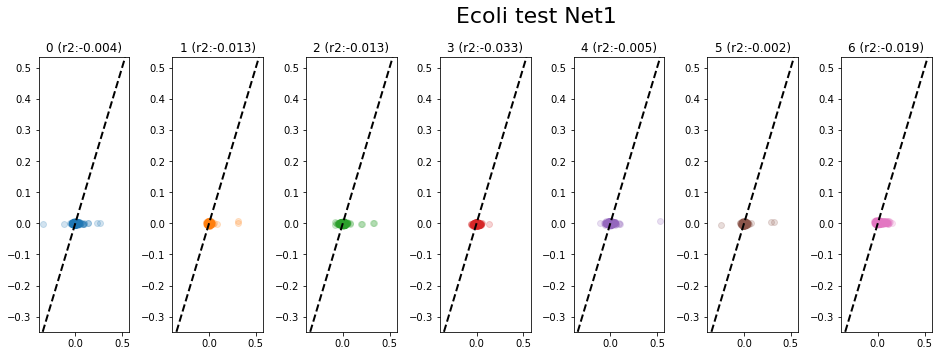

In [20]:
yfull_train_pred = net_regr1.predict(Xfull_train)
    

view_multi_parity("Ecoli test Net1", 
    yfull_train, 
    yfull_train_pred,
    rigid=True)

For all tasks, defaulting to about 0, aka "not in iModulon"
* are any iMods better than others?
* do an initial skorch search to see if any hyperparams stand out?
* then dip back to data aug... cross val
* mbinarized



# SKORCH search

In [21]:
from sklearn.model_selection import RandomizedSearchCV


In [22]:
net_search = NeuralNetRegressor(
    m.DNA_2CNN_2FC_Multi,
    module__seq_len=300,
    module__n_tasks=y.shape[1],
    max_epochs=1000,
    #lr=0.001,
    device=DEVICE,
    callbacks=[
         EarlyStopping(patience=500),
         Checkpoint(load_best=True),
         GradientNormClipping()
     ],

)

In [23]:
params = {
    'lr': [0.01, 0.001, 0.0001,],#loguniform(0.0001, 0.01)
    
    'module__num_filters1': [16,32,64,128],
    'module__num_filters2': [16,32,64,128],
    'module__kernel_size1': [4,8,16,32],
    'module__kernel_size2': [4,8,16,32],
    'module__conv_pool_size1': [2,4,8,16],
    'module__fc_node_num1': [10,50,100,500],
    'module__fc_node_num2': [10,50,100,500],
    'module__dropout1': [0.0,0.2,0.4],
    'module__dropout2': [0.0,0.2,0.4],
    'optimizer':[torch.optim.SGD, torch.optim.Adam,torch.optim.AdamW,torch.optim.RMSprop]
    #'optimizer__nesterov': [False, True],
}

In [24]:
search = RandomizedSearchCV(
    net_search, 
    params, 
    n_iter=5, 
    #scoring='neg_mean_absolute_error', 
    scoring='neg_mean_squared_error', 
    #n_jobs=-1, 
    cv=3,#cv, 
    random_state=7,
    verbose=0
)

In [25]:
search.fit(Xfull_train,yfull_train)

  epoch      train_loss    valid_loss    cp     dur
-------  --------------  ------------  ----  ------
      1  127154744.9229        0.0191     +  0.0704
      2        1.0617        0.0210        0.0600
      3        0.0163        0.0152     +  0.0578
      4        0.0121        0.0110     +  0.0568
      5        0.0094        0.0084     +  0.0475
      6        0.0083        0.0076     +  0.0471
      7        0.0078        0.0073     +  0.0474
      8        0.0077        0.0075        0.0444
      9        0.0075        0.0072     +  0.0431
     10        0.0074        0.0072        0.0421
     11        0.0074        0.0071     +  0.0426
     12        0.0074        0.0072        0.0418
     13        0.0073        0.0070     +  0.0393
     14        0.0072        0.0071        0.0394
     15        0.0071        0.0070     +  0.0395
     16        0.0071        0.0071        0.0393
     17        0.0071        0.0072        0.0393
     18        0.0071        0.0069     +  0

    145        0.0034        0.0041     +  0.0410
    146        0.0033        0.0045        0.0395
    147        0.0035        0.0049        0.0390
    148        0.0034        0.0045        0.0396
    149        0.0033        0.0035     +  0.0387
    150        0.0029        0.0033     +  0.0384
    151        0.0029        0.0034        0.0387
    152        0.0029        0.0040        0.0386
    153        0.0030        0.0034        0.0388
    154        0.0026        0.0034        0.0396
    155        0.0027        0.0038        0.0378
    156        0.0028        0.0040        0.0380
    157        0.0025        0.0041        0.0396
    158        0.0025        0.0032     +  0.0384
    159        0.0022        0.0033        0.0403
    160        0.0022        0.0031     +  0.0386
    161        0.0022        0.0026     +  0.0388
    162        0.0019        0.0022     +  0.0398
    163        0.0019        0.0020     +  0.0380
    164        0.0019        0.0016     +  0.0410


    300        0.0005        0.0011        0.0377
    301        0.0005        0.0008        0.0377
    302        0.0004        0.0007        0.0392
    303        0.0004        0.0007        0.0377
    304        0.0004        0.0007        0.0374
    305        0.0004        0.0009        0.0405
    306        0.0005        0.0011        0.0381
    307        0.0005        0.0007        0.0382
    308        0.0004        0.0006        0.0393
    309        0.0004        0.0007        0.0381
    310        0.0004        0.0007        0.0381
    311        0.0004        0.0011        0.0385
    312        0.0005        0.0008        0.0386
    313        0.0004        0.0006        0.0384
    314        0.0004        0.0007        0.0381
    315        0.0004        0.0008        0.0391
    316        0.0005        0.0010        0.0381
    317        0.0004        0.0008        0.0391
    318        0.0004        0.0009        0.0411
    319        0.0004        0.0007        0.0385


    461        0.0003        0.0003        0.0385
    462        0.0003        0.0003        0.0402
    463        0.0004        0.0004        0.0377
    464        0.0005        0.0004        0.0377
    465        0.0004        0.0003        0.0396
    466        0.0003        0.0003        0.0379
    467        0.0003        0.0003        0.0379
    468        0.0003        0.0002        0.0392
    469        0.0003        0.0003        0.0378
    470        0.0003        0.0003        0.0378
    471        0.0003        0.0003        0.0395
    472        0.0003        0.0003        0.0385
    473        0.0004        0.0006        0.0379
    474        0.0005        0.0003        0.0387
    475        0.0003        0.0003        0.0387
    476        0.0003        0.0003        0.0378
    477        0.0003        0.0002        0.0380
    478        0.0003        0.0003        0.0391
    479        0.0003        0.0003        0.0386
    480        0.0003        0.0003        0.0386


    623        0.0003        0.0003        0.0385
    624        0.0003        0.0003        0.0382
    625        0.0003        0.0003        0.0397
    626        0.0003        0.0003        0.0390
    627        0.0003        0.0003        0.0393
    628        0.0003        0.0003        0.0386
    629        0.0003        0.0003        0.0397
    630        0.0003        0.0003        0.0383
    631        0.0003        0.0003        0.0389
    632        0.0003        0.0003        0.0395
    633        0.0003        0.0003        0.0379
    634        0.0003        0.0003        0.0383
    635        0.0003        0.0003        0.0393
    636        0.0003        0.0003        0.0385
    637        0.0003        0.0003        0.0384
    638        0.0003        0.0003        0.0392
    639        0.0003        0.0003        0.0382
    640        0.0003        0.0003        0.0390
    641        0.0003        0.0003        0.0388
    642        0.0003        0.0003        0.0386


    787        0.0003        0.0003        0.0396
    788        0.0003        0.0003        0.0393
    789        0.0003        0.0003        0.0396
    790        0.0003        0.0003        0.0393
    791        0.0003        0.0003        0.0385
    792        0.0003        0.0003        0.0393
    793        0.0003        0.0003        0.0381
    794        0.0003        0.0003        0.0397
    795        0.0003        0.0003        0.0385
    796        0.0003        0.0003        0.0393
    797        0.0003        0.0003        0.0387
    798        0.0003        0.0003        0.0381
    799        0.0003        0.0003        0.0395
    800        0.0003        0.0003        0.0392
    801        0.0003        0.0003        0.0388
    802        0.0003        0.0003        0.0389
    803        0.0003        0.0003        0.0382
    804        0.0003        0.0003        0.0392
    805        0.0003        0.0003        0.0392
    806        0.0003        0.0003        0.0385


    951        0.0003        0.0003        0.0398
    952        0.0003        0.0003        0.0380
    953        0.0003        0.0003        0.0392
    954        0.0003        0.0003        0.0383
    955        0.0003        0.0003        0.0391
    956        0.0003        0.0003        0.0392
    957        0.0003        0.0003        0.0388
    958        0.0003        0.0003        0.0399
    959        0.0003        0.0003        0.0384
    960        0.0003        0.0003        0.0394
    961        0.0003        0.0003        0.0387
    962        0.0003        0.0003        0.0392
    963        0.0003        0.0003        0.0390
    964        0.0003        0.0003        0.0389
    965        0.0003        0.0003        0.0391
    966        0.0003        0.0003        0.0383
    967        0.0003        0.0003        0.0392
    968        0.0003        0.0003        0.0385
    969        0.0003        0.0003        0.0390
    970        0.0003        0.0003        0.0390


     89        0.0166        0.0163     +  0.0407
     90        0.0162        0.0160     +  0.0428
     91        0.0159        0.0157     +  0.0408
     92        0.0156        0.0154     +  0.0395
     93        0.0153        0.0151     +  0.0389
     94        0.0151        0.0148     +  0.0409
     95        0.0147        0.0144     +  0.0402
     96        0.0143        0.0140     +  0.0399
     97        0.0140        0.0137     +  0.0395
     98        0.0136        0.0134     +  0.0403
     99        0.0134        0.0131     +  0.0406
    100        0.0130        0.0126     +  0.0389
    101        0.0126        0.0123     +  0.0393
    102        0.0123        0.0119     +  0.0398
    103        0.0119        0.0116     +  0.0398
    104        0.0115        0.0112     +  0.0402
    105        0.0111        0.0109     +  0.0408
    106        0.0110        0.0107     +  0.0409
    107        0.0105        0.0101     +  0.0411
    108        0.0100        0.0097     +  0.0401


    227        0.0003        0.0003        0.0389
    228        0.0003        0.0003        0.0386
    229        0.0004        0.0003        0.0378
    230        0.0003        0.0003        0.0386
    231        0.0004        0.0003        0.0392
    232        0.0004        0.0003        0.0377
    233        0.0004        0.0003        0.0381
    234        0.0003        0.0003        0.0391
    235        0.0003        0.0003        0.0389
    236        0.0003        0.0003        0.0387
    237        0.0004        0.0003        0.0396
    238        0.0004        0.0003        0.0401
    239        0.0004        0.0003        0.0404
    240        0.0003        0.0003        0.0390
    241        0.0003        0.0003        0.0381
    242        0.0004        0.0003        0.0389
    243        0.0003        0.0003        0.0385
    244        0.0003        0.0003        0.0389
    245        0.0003        0.0003        0.0390
    246        0.0004        0.0003        0.0386


    391        0.0003        0.0002        0.0388
    392        0.0003        0.0004        0.0378
    393        0.0004        0.0003        0.0376
    394        0.0003        0.0003        0.0394
    395        0.0003        0.0003        0.0378
    396        0.0003        0.0004        0.0377
    397        0.0004        0.0003        0.0394
    398        0.0003        0.0003        0.0393
    399        0.0003        0.0003        0.0388
    400        0.0003        0.0002        0.0381
    401        0.0003        0.0004        0.0391
    402        0.0004        0.0003        0.0392
    403        0.0003        0.0003        0.0378
    404        0.0003        0.0003        0.0400
    405        0.0003        0.0003        0.0385
    406        0.0003        0.0002        0.0396
    407        0.0003        0.0002        0.0379
    408        0.0003        0.0002        0.0393
    409        0.0003        0.0004        0.0382
    410        0.0004        0.0003        0.0379


    554        0.0003        0.0002        0.0380
    555        0.0003        0.0002        0.0381
    556        0.0003        0.0002        0.0406
    557        0.0003        0.0002        0.0388
    558        0.0003        0.0002        0.0381
    559        0.0003        0.0002        0.0405
    560        0.0003        0.0002        0.0391
    561        0.0003        0.0002        0.0391
    562        0.0003        0.0002        0.0402
    563        0.0003        0.0002        0.0399
    564        0.0003        0.0002        0.0393
    565        0.0003        0.0002        0.0404
    566        0.0003        0.0002        0.0400
    567        0.0003        0.0002        0.0384
    568        0.0003        0.0002        0.0397
    569        0.0003        0.0002        0.0402
    570        0.0003        0.0002        0.0383
    571        0.0003        0.0002        0.0386
    572        0.0003        0.0002        0.0395
    573        0.0003        0.0002        0.0382


    718        0.0003        0.0002        0.0399
    719        0.0003        0.0002        0.0380
    720        0.0003        0.0002        0.0378
    721        0.0003        0.0002        0.0395
    722        0.0003        0.0002        0.0383
    723        0.0003        0.0002        0.0380
    724        0.0003        0.0002        0.0388
    725        0.0003        0.0002        0.0390
    726        0.0003        0.0002        0.0378
    727        0.0003        0.0002        0.0387
    728        0.0003        0.0002        0.0391
    729        0.0003        0.0002        0.0380
    730        0.0003        0.0002        0.0382
    731        0.0003        0.0002        0.0399
    732        0.0003        0.0002        0.0381
    733        0.0003        0.0002        0.0378
    734        0.0003        0.0002        0.0397
    735        0.0003        0.0002        0.0378
    736        0.0003        0.0002        0.0379
    737        0.0003        0.0002        0.0398


    108        0.0100        0.0100     +  0.0382
    109        0.0097        0.0101        0.0398
    110        0.0101        0.0114        0.0389
    111        0.0095        0.0097     +  0.0379
    112        0.0091        0.0091     +  0.0400
    113        0.0088        0.0092        0.0384
    114        0.0086        0.0090     +  0.0379
    115        0.0085        0.0093        0.0401
    116        0.0084        0.0084     +  0.0382
    117        0.0082        0.0091        0.0390
    118        0.0081        0.0088        0.0399
    119        0.0078        0.0082     +  0.0381
    120        0.0074        0.0073     +  0.0399
    121        0.0071        0.0069     +  0.0394
    122        0.0069        0.0067     +  0.0391
    123        0.0068        0.0065     +  0.0393
    124        0.0073        0.0062     +  0.0389
    125        0.0064        0.0062     +  0.0409
    126        0.0061        0.0062        0.0392
    127        0.0060        0.0064        0.0397


    251        0.0006        0.0002        0.0391
    252        0.0004        0.0002        0.0388
    253        0.0003        0.0002        0.0398
    254        0.0005        0.0003        0.0386
    255        0.0006        0.0003        0.0396
    256        0.0005        0.0002        0.0391
    257        0.0004        0.0002     +  0.0393
    258        0.0004        0.0002        0.0391
    259        0.0005        0.0003        0.0395
    260        0.0005        0.0002        0.0388
    261        0.0004        0.0002        0.0394
    262        0.0004        0.0002        0.0383
    263        0.0005        0.0003        0.0380
    264        0.0006        0.0002        0.0399
    265        0.0004        0.0002        0.0382
    266        0.0003        0.0002        0.0380
    267        0.0004        0.0003        0.0403
    268        0.0005        0.0003        0.0383
    269        0.0006        0.0002        0.0381
    270        0.0004        0.0002        0.0406


    414        0.0003        0.0003        0.0378
    415        0.0004        0.0004        0.0409
    416        0.0005        0.0004        0.0385
    417        0.0004        0.0002        0.0383
    418        0.0003        0.0002        0.0402
    419        0.0003        0.0003        0.0386
    420        0.0004        0.0003        0.0402
    421        0.0004        0.0003        0.0386
    422        0.0004        0.0003        0.0392
    423        0.0003        0.0002        0.0388
    424        0.0003        0.0002        0.0382
    425        0.0003        0.0003        0.0397
    426        0.0004        0.0004        0.0384
    427        0.0005        0.0003        0.0389
    428        0.0004        0.0003        0.0390
    429        0.0004        0.0002        0.0382
    430        0.0003        0.0002        0.0388
    431        0.0003        0.0002        0.0383
    432        0.0003        0.0003        0.0388
    433        0.0004        0.0004        0.0379


    577        0.0003        0.0002        0.0387
    578        0.0003        0.0002        0.0381
    579        0.0003        0.0002        0.0380
    580        0.0003        0.0002        0.0385
    581        0.0003        0.0002        0.0386
    582        0.0003        0.0002        0.0379
    583        0.0003        0.0002        0.0381
    584        0.0003        0.0002        0.0380
    585        0.0003        0.0002        0.0380
    586        0.0003        0.0002        0.0381
    587        0.0003        0.0002        0.0387
    588        0.0003        0.0002        0.0394
    589        0.0003        0.0002        0.0391
    590        0.0003        0.0002        0.0381
    591        0.0003        0.0002        0.0384
    592        0.0003        0.0002        0.0380
    593        0.0003        0.0002        0.0380
    594        0.0003        0.0002        0.0379
    595        0.0003        0.0002        0.0379
    596        0.0003        0.0003        0.0378


    741        0.0003        0.0002        0.0396
    742        0.0003        0.0002        0.0381
    743        0.0003        0.0002        0.0378
    744        0.0003        0.0002        0.0385
    745        0.0003        0.0002        0.0395
    746        0.0003        0.0002        0.0376
    747        0.0003        0.0002        0.0381
    748        0.0003        0.0002        0.0391
    749        0.0003        0.0002        0.0381
    750        0.0003        0.0002        0.0387
    751        0.0003        0.0002        0.0398
    752        0.0003        0.0002        0.0382
    753        0.0003        0.0002        0.0379
    754        0.0003        0.0002        0.0404
    755        0.0003        0.0002        0.0383
    756        0.0003        0.0002        0.0380
    757        0.0003        0.0002        0.0405
    758        0.0003        0.0002        0.0387
    759        0.0003        0.0002        0.0384
    760        0.0003        0.0002        0.0400


    905        0.0003        0.0002        0.0386
    906        0.0003        0.0002        0.0380
    907        0.0003        0.0002        0.0381
    908        0.0003        0.0002        0.0381
    909        0.0003        0.0002        0.0426
    910        0.0003        0.0002        0.0394
    911        0.0003        0.0002        0.0379
    912        0.0003        0.0002        0.0380
    913        0.0003        0.0002        0.0392
    914        0.0003        0.0002        0.0388
    915        0.0003        0.0002        0.0394
    916        0.0003        0.0002        0.0381
    917        0.0003        0.0002        0.0398
    918        0.0003        0.0002        0.0391
    919        0.0003        0.0002        0.0387
    920        0.0003        0.0002        0.0394
    921        0.0003        0.0002        0.0383
    922        0.0003        0.0002        0.0391
    923        0.0003        0.0002        0.0385
    924        0.0003        0.0002        0.0400


     53        0.0056        0.0054     +  0.0389
     54        0.0056        0.0054     +  0.0388
     55        0.0055        0.0054     +  0.0383
     56        0.0055        0.0054     +  0.0382
     57        0.0055        0.0054     +  0.0398
     58        0.0055        0.0054     +  0.0385
     59        0.0055        0.0054     +  0.0379
     60        0.0055        0.0054     +  0.0395
     61        0.0055        0.0053     +  0.0384
     62        0.0055        0.0053     +  0.0397
     63        0.0055        0.0053     +  0.0391
     64        0.0055        0.0053     +  0.0385
     65        0.0055        0.0053     +  0.0397
     66        0.0055        0.0053     +  0.0380
     67        0.0055        0.0053     +  0.0387
     68        0.0055        0.0053     +  0.0391
     69        0.0055        0.0053     +  0.0378
     70        0.0055        0.0053     +  0.0400
     71        0.0055        0.0053     +  0.0389
     72        0.0055        0.0053     +  0.0381


    181        0.0050        0.0048     +  0.0426
    182        0.0050        0.0048     +  0.0420
    183        0.0050        0.0048     +  0.0419
    184        0.0050        0.0048     +  0.0430
    185        0.0050        0.0048     +  0.0419
    186        0.0050        0.0048     +  0.0430
    187        0.0050        0.0048     +  0.0412
    188        0.0050        0.0048     +  0.0436
    189        0.0050        0.0048     +  0.0429
    190        0.0050        0.0048     +  0.0424
    191        0.0049        0.0048     +  0.0431
    192        0.0050        0.0048     +  0.0426
    193        0.0049        0.0048     +  0.0439
    194        0.0049        0.0048     +  0.0437
    195        0.0049        0.0048     +  0.0435
    196        0.0049        0.0048     +  0.0426
    197        0.0049        0.0048     +  0.0424
    198        0.0049        0.0047     +  0.0421
    199        0.0049        0.0047     +  0.0424
    200        0.0049        0.0047     +  0.0430


    310        0.0045        0.0043     +  0.0456
    311        0.0045        0.0043     +  0.0472
    312        0.0045        0.0043     +  0.0456
    313        0.0045        0.0043     +  0.0474
    314        0.0045        0.0043     +  0.0447
    315        0.0045        0.0043     +  0.0460
    316        0.0045        0.0043     +  0.0449
    317        0.0045        0.0043     +  0.0451
    318        0.0045        0.0043     +  0.0461
    319        0.0045        0.0043     +  0.0451
    320        0.0044        0.0043     +  0.0470
    321        0.0044        0.0043     +  0.0447
    322        0.0044        0.0043     +  0.0452
    323        0.0044        0.0043     +  0.0462
    324        0.0044        0.0043     +  0.0462
    325        0.0044        0.0043     +  0.0473
    326        0.0044        0.0043     +  0.0452
    327        0.0044        0.0043     +  0.0467
    328        0.0044        0.0043     +  0.0453
    329        0.0044        0.0043     +  0.0446


    439        0.0040        0.0039     +  0.0514
    440        0.0040        0.0039     +  0.0506
    441        0.0040        0.0039     +  0.0509
    442        0.0040        0.0039     +  0.0517
    443        0.0040        0.0039     +  0.0504
    444        0.0040        0.0039     +  0.0505
    445        0.0040        0.0039     +  0.0520
    446        0.0040        0.0039     +  0.0503
    447        0.0040        0.0039     +  0.0506
    448        0.0040        0.0039     +  0.0521
    449        0.0040        0.0039     +  0.0515
    450        0.0040        0.0038     +  0.0509
    451        0.0040        0.0038     +  0.0529
    452        0.0040        0.0038     +  0.0524
    453        0.0040        0.0038     +  0.0514
    454        0.0040        0.0038     +  0.0513
    455        0.0040        0.0038     +  0.0530
    456        0.0040        0.0038     +  0.0519
    457        0.0040        0.0038     +  0.0517
    458        0.0040        0.0038     +  0.0515


    569        0.0036        0.0035     +  0.0585
    570        0.0036        0.0035     +  0.0577
    571        0.0036        0.0035     +  0.0575
    572        0.0036        0.0035     +  0.0584
    573        0.0036        0.0035     +  0.0592
    574        0.0036        0.0035     +  0.0593
    575        0.0036        0.0035     +  0.0595
    576        0.0036        0.0035     +  0.0584
    577        0.0036        0.0035     +  0.0591
    578        0.0036        0.0035     +  0.0584
    579        0.0036        0.0035     +  0.0611
    580        0.0036        0.0035     +  0.0582
    581        0.0036        0.0035     +  0.0578
    582        0.0036        0.0035     +  0.0582
    583        0.0036        0.0035     +  0.0574
    584        0.0036        0.0035     +  0.0586
    585        0.0036        0.0035     +  0.0592
    586        0.0036        0.0034     +  0.0573
    587        0.0036        0.0034     +  0.0574
    588        0.0036        0.0034     +  0.0574


    698        0.0033        0.0032     +  0.0588
    699        0.0033        0.0032     +  0.0597
    700        0.0033        0.0032     +  0.0587
    701        0.0033        0.0031     +  0.0591
    702        0.0033        0.0031     +  0.0603
    703        0.0033        0.0031     +  0.0591
    704        0.0033        0.0031     +  0.0574
    705        0.0033        0.0031     +  0.0579
    706        0.0033        0.0031     +  0.0578
    707        0.0033        0.0031     +  0.0583
    708        0.0033        0.0031     +  0.0577
    709        0.0033        0.0031     +  0.0579
    710        0.0033        0.0031     +  0.0581
    711        0.0033        0.0031     +  0.0586
    712        0.0033        0.0031     +  0.0594
    713        0.0033        0.0031     +  0.0592
    714        0.0033        0.0031     +  0.0598
    715        0.0033        0.0031     +  0.0591
    716        0.0032        0.0031     +  0.0589
    717        0.0033        0.0031     +  0.0581


    828        0.0030        0.0029     +  0.0611
    829        0.0030        0.0028     +  0.0606
    830        0.0030        0.0028     +  0.0606
    831        0.0030        0.0028     +  0.0610
    832        0.0030        0.0028     +  0.0605
    833        0.0030        0.0028     +  0.0619
    834        0.0030        0.0028     +  0.0616
    835        0.0030        0.0028     +  0.0604
    836        0.0030        0.0028     +  0.0614
    837        0.0030        0.0028     +  0.0622
    838        0.0030        0.0028     +  0.0604
    839        0.0030        0.0028     +  0.0609
    840        0.0030        0.0028     +  0.0608
    841        0.0029        0.0028     +  0.0599
    842        0.0030        0.0028     +  0.0597
    843        0.0030        0.0028     +  0.0599
    844        0.0029        0.0028     +  0.0607
    845        0.0029        0.0028     +  0.0605
    846        0.0029        0.0028     +  0.0605
    847        0.0029        0.0028     +  0.0600


    958        0.0027        0.0026     +  0.0599
    959        0.0027        0.0026     +  0.0591
    960        0.0027        0.0026     +  0.0594
    961        0.0027        0.0026     +  0.0613
    962        0.0027        0.0026     +  0.0600
    963        0.0027        0.0026     +  0.0599
    964        0.0027        0.0026     +  0.0608
    965        0.0027        0.0026     +  0.0618
    966        0.0027        0.0026     +  0.0618
    967        0.0027        0.0026     +  0.0626
    968        0.0027        0.0026     +  0.0625
    969        0.0027        0.0026     +  0.0618
    970        0.0027        0.0026     +  0.0600
    971        0.0027        0.0026     +  0.0605
    972        0.0027        0.0026     +  0.0586
    973        0.0027        0.0025     +  0.0586
    974        0.0027        0.0025     +  0.0585
    975        0.0027        0.0025     +  0.0598
    976        0.0027        0.0025     +  0.0602
    977        0.0027        0.0025     +  0.0598


     85        0.0071        0.0071     +  0.0401
     86        0.0071        0.0071     +  0.0397
     87        0.0071        0.0071     +  0.0397
     88        0.0071        0.0071     +  0.0398
     89        0.0071        0.0071     +  0.0395
     90        0.0071        0.0071     +  0.0394
     91        0.0071        0.0071     +  0.0396
     92        0.0071        0.0071     +  0.0399
     93        0.0071        0.0070     +  0.0399
     94        0.0070        0.0070     +  0.0398
     95        0.0070        0.0070     +  0.0395
     96        0.0070        0.0070     +  0.0405
     97        0.0070        0.0070     +  0.0390
     98        0.0070        0.0070     +  0.0384
     99        0.0070        0.0070     +  0.0389
    100        0.0070        0.0070     +  0.0386
    101        0.0070        0.0070     +  0.0407
    102        0.0070        0.0070     +  0.0389
    103        0.0070        0.0070     +  0.0397
    104        0.0070        0.0070     +  0.0394


    213        0.0064        0.0064     +  0.0427
    214        0.0064        0.0064     +  0.0442
    215        0.0064        0.0064     +  0.0432
    216        0.0064        0.0064     +  0.0456
    217        0.0064        0.0064     +  0.0425
    218        0.0064        0.0064     +  0.0445
    219        0.0064        0.0064     +  0.0426
    220        0.0064        0.0064     +  0.0455
    221        0.0064        0.0064     +  0.0447
    222        0.0064        0.0064     +  0.0472
    223        0.0064        0.0064     +  0.0439
    224        0.0064        0.0064     +  0.0451
    225        0.0064        0.0064     +  0.0440
    226        0.0064        0.0064     +  0.0442
    227        0.0064        0.0063     +  0.0447
    228        0.0064        0.0063     +  0.0450
    229        0.0064        0.0063     +  0.0445
    230        0.0063        0.0063     +  0.0437
    231        0.0063        0.0063     +  0.0431
    232        0.0063        0.0063     +  0.0427


    340        0.0058        0.0058     +  0.0464
    341        0.0058        0.0058     +  0.0473
    342        0.0058        0.0058     +  0.0485
    343        0.0058        0.0058     +  0.0457
    344        0.0058        0.0058     +  0.0477
    345        0.0058        0.0058     +  0.0459
    346        0.0058        0.0058     +  0.0467
    347        0.0058        0.0058     +  0.0474
    348        0.0058        0.0058     +  0.0476
    349        0.0058        0.0058     +  0.0472
    350        0.0058        0.0058     +  0.0475
    351        0.0058        0.0058     +  0.0472
    352        0.0058        0.0058     +  0.0466
    353        0.0058        0.0058     +  0.0466
    354        0.0058        0.0058     +  0.0477
    355        0.0058        0.0058     +  0.0485
    356        0.0058        0.0058     +  0.0503
    357        0.0058        0.0057     +  0.0495
    358        0.0058        0.0057     +  0.0474
    359        0.0058        0.0057     +  0.0471


    467        0.0053        0.0053     +  0.0520
    468        0.0053        0.0053     +  0.0534
    469        0.0053        0.0053     +  0.0519
    470        0.0053        0.0053     +  0.0525
    471        0.0053        0.0053     +  0.0536
    472        0.0053        0.0053     +  0.0536
    473        0.0053        0.0053     +  0.0520
    474        0.0053        0.0053     +  0.0519
    475        0.0053        0.0053     +  0.0542
    476        0.0053        0.0053     +  0.0532
    477        0.0053        0.0052     +  0.0530
    478        0.0053        0.0052     +  0.0528
    479        0.0052        0.0052     +  0.0550
    480        0.0052        0.0052     +  0.0531
    481        0.0052        0.0052     +  0.0529
    482        0.0052        0.0052     +  0.0535
    483        0.0052        0.0052     +  0.0548
    484        0.0052        0.0052     +  0.0535
    485        0.0052        0.0052     +  0.0532
    486        0.0052        0.0052     +  0.0545


    596        0.0048        0.0048     +  0.0613
    597        0.0048        0.0048     +  0.0615
    598        0.0048        0.0048     +  0.0610
    599        0.0048        0.0048     +  0.0595
    600        0.0048        0.0048     +  0.0596
    601        0.0048        0.0048     +  0.0587
    602        0.0048        0.0048     +  0.0594
    603        0.0048        0.0048     +  0.0604
    604        0.0048        0.0048     +  0.0593
    605        0.0048        0.0048     +  0.0605
    606        0.0048        0.0048     +  0.0614
    607        0.0048        0.0048     +  0.0605
    608        0.0048        0.0048     +  0.0613
    609        0.0048        0.0048     +  0.0605
    610        0.0048        0.0047     +  0.0607
    611        0.0048        0.0047     +  0.0602
    612        0.0048        0.0047     +  0.0597
    613        0.0048        0.0047     +  0.0603
    614        0.0047        0.0047     +  0.0592
    615        0.0047        0.0047     +  0.0602


    725        0.0044        0.0044     +  0.0598
    726        0.0044        0.0043     +  0.0603
    727        0.0044        0.0043     +  0.0599
    728        0.0044        0.0043     +  0.0586
    729        0.0044        0.0043     +  0.0597
    730        0.0044        0.0043     +  0.0614
    731        0.0044        0.0043     +  0.0610
    732        0.0043        0.0043     +  0.0604
    733        0.0043        0.0043     +  0.0620
    734        0.0043        0.0043     +  0.0612
    735        0.0043        0.0043     +  0.0616
    736        0.0043        0.0043     +  0.0595
    737        0.0043        0.0043     +  0.0616
    738        0.0043        0.0043     +  0.0618
    739        0.0043        0.0043     +  0.0616
    740        0.0043        0.0043     +  0.0615
    741        0.0043        0.0043     +  0.0628
    742        0.0043        0.0043     +  0.0601
    743        0.0043        0.0043     +  0.0599
    744        0.0043        0.0043     +  0.0601


    854        0.0040        0.0039     +  0.0590
    855        0.0040        0.0039     +  0.0600
    856        0.0040        0.0039     +  0.0603
    857        0.0040        0.0039     +  0.0607
    858        0.0039        0.0039     +  0.0603
    859        0.0039        0.0039     +  0.0605
    860        0.0039        0.0039     +  0.0603
    861        0.0039        0.0039     +  0.0609
    862        0.0039        0.0039     +  0.0601
    863        0.0039        0.0039     +  0.0605
    864        0.0039        0.0039     +  0.0594
    865        0.0039        0.0039     +  0.0596
    866        0.0039        0.0039     +  0.0616
    867        0.0039        0.0039     +  0.0615
    868        0.0039        0.0039     +  0.0598
    869        0.0039        0.0039     +  0.0587
    870        0.0039        0.0039     +  0.0593
    871        0.0039        0.0039     +  0.0595
    872        0.0039        0.0039     +  0.0604
    873        0.0039        0.0039     +  0.0613


    985        0.0036        0.0036     +  0.0634
    986        0.0036        0.0036     +  0.0633
    987        0.0036        0.0036     +  0.0638
    988        0.0036        0.0036     +  0.0632
    989        0.0036        0.0036     +  0.0602
    990        0.0036        0.0036     +  0.0604
    991        0.0036        0.0036     +  0.0600
    992        0.0036        0.0036     +  0.0601
    993        0.0036        0.0036     +  0.0591
    994        0.0036        0.0035     +  0.0590
    995        0.0036        0.0035     +  0.0591
    996        0.0036        0.0035     +  0.0590
    997        0.0036        0.0035     +  0.0587
    998        0.0036        0.0035     +  0.0590
    999        0.0036        0.0035     +  0.0597
   1000        0.0035        0.0035     +  0.0623
  epoch    train_loss    valid_loss    cp     dur
-------  ------------  ------------  ----  ------
      1        0.0047        0.0046     +  0.0608
      2        0.0047        0.0046     +  0.0644


    114        0.0043        0.0042     +  0.0397
    115        0.0043        0.0042     +  0.0417
    116        0.0043        0.0042     +  0.0405
    117        0.0043        0.0042     +  0.0430
    118        0.0043        0.0042     +  0.0399
    119        0.0043        0.0042     +  0.0419
    120        0.0043        0.0042     +  0.0406
    121        0.0043        0.0042     +  0.0400
    122        0.0043        0.0042     +  0.0410
    123        0.0043        0.0042     +  0.0406
    124        0.0043        0.0042     +  0.0428
    125        0.0043        0.0042     +  0.0414
    126        0.0043        0.0042     +  0.0419
    127        0.0043        0.0042     +  0.0418
    128        0.0043        0.0042     +  0.0405
    129        0.0043        0.0042     +  0.0405
    130        0.0043        0.0042     +  0.0414
    131        0.0043        0.0042     +  0.0418
    132        0.0043        0.0042     +  0.0408
    133        0.0042        0.0042     +  0.0402


    245        0.0039        0.0038     +  0.0462
    246        0.0039        0.0038     +  0.0464
    247        0.0039        0.0038     +  0.0465
    248        0.0039        0.0038     +  0.0462
    249        0.0039        0.0038     +  0.0450
    250        0.0039        0.0038     +  0.0454
    251        0.0039        0.0038     +  0.0484
    252        0.0039        0.0038     +  0.0448
    253        0.0039        0.0038     +  0.0466
    254        0.0039        0.0038     +  0.0445
    255        0.0039        0.0038     +  0.0457
    256        0.0039        0.0038     +  0.0466
    257        0.0039        0.0038     +  0.0452
    258        0.0039        0.0038     +  0.0456
    259        0.0038        0.0038     +  0.0460
    260        0.0038        0.0038     +  0.0467
    261        0.0039        0.0038     +  0.0463
    262        0.0038        0.0038     +  0.0464
    263        0.0038        0.0037     +  0.0473
    264        0.0038        0.0037     +  0.0474


    374        0.0035        0.0034     +  0.0487
    375        0.0035        0.0034     +  0.0474
    376        0.0035        0.0034     +  0.0477
    377        0.0035        0.0034     +  0.0484
    378        0.0035        0.0034     +  0.0469
    379        0.0035        0.0034     +  0.0470
    380        0.0035        0.0034     +  0.0476
    381        0.0035        0.0034     +  0.0478
    382        0.0035        0.0034     +  0.0488
    383        0.0035        0.0034     +  0.0477
    384        0.0035        0.0034     +  0.0474
    385        0.0035        0.0034     +  0.0492
    386        0.0035        0.0034     +  0.0471
    387        0.0035        0.0034     +  0.0486
    388        0.0035        0.0034     +  0.0492
    389        0.0035        0.0034     +  0.0494
    390        0.0035        0.0034     +  0.0503
    391        0.0035        0.0034     +  0.0490
    392        0.0035        0.0034     +  0.0486
    393        0.0035        0.0034     +  0.0517


    505        0.0032        0.0031     +  0.0592
    506        0.0032        0.0031     +  0.0608
    507        0.0032        0.0031     +  0.0607
    508        0.0032        0.0031     +  0.0604
    509        0.0032        0.0031     +  0.0611
    510        0.0032        0.0031     +  0.0603
    511        0.0032        0.0031     +  0.0613
    512        0.0032        0.0031     +  0.0614
    513        0.0032        0.0031     +  0.0599
    514        0.0032        0.0031     +  0.0613
    515        0.0032        0.0031     +  0.0623
    516        0.0032        0.0031     +  0.0615
    517        0.0032        0.0031     +  0.0622
    518        0.0031        0.0031     +  0.0614
    519        0.0031        0.0031     +  0.0613
    520        0.0031        0.0031     +  0.0615
    521        0.0031        0.0031     +  0.0613
    522        0.0031        0.0030     +  0.0614
    523        0.0031        0.0030     +  0.0615
    524        0.0031        0.0030     +  0.0599


    634        0.0029        0.0028     +  0.0641
    635        0.0029        0.0028     +  0.0623
    636        0.0029        0.0028     +  0.0608
    637        0.0029        0.0028     +  0.0606
    638        0.0029        0.0028     +  0.0608
    639        0.0029        0.0028     +  0.0607
    640        0.0029        0.0028     +  0.0613
    641        0.0029        0.0028     +  0.0619
    642        0.0029        0.0028     +  0.0615
    643        0.0029        0.0028     +  0.0613
    644        0.0029        0.0028     +  0.0605
    645        0.0029        0.0028     +  0.0591
    646        0.0029        0.0028     +  0.0589
    647        0.0029        0.0028     +  0.0595
    648        0.0028        0.0028     +  0.0607
    649        0.0029        0.0028     +  0.0616
    650        0.0028        0.0028     +  0.0610
    651        0.0028        0.0027     +  0.0612
    652        0.0028        0.0027     +  0.0612
    653        0.0028        0.0027     +  0.0615


    766        0.0026        0.0025     +  0.0614
    767        0.0026        0.0025     +  0.0635
    768        0.0026        0.0025     +  0.0628
    769        0.0026        0.0025     +  0.0632
    770        0.0026        0.0025     +  0.0633
    771        0.0026        0.0025     +  0.0603
    772        0.0026        0.0025     +  0.0606
    773        0.0026        0.0025     +  0.0618
    774        0.0026        0.0025     +  0.0602
    775        0.0026        0.0025     +  0.0598
    776        0.0026        0.0025     +  0.0596
    777        0.0026        0.0025     +  0.0594
    778        0.0026        0.0025     +  0.0591
    779        0.0026        0.0025     +  0.0599
    780        0.0026        0.0025     +  0.0586
    781        0.0026        0.0025     +  0.0585
    782        0.0026        0.0025     +  0.0601
    783        0.0026        0.0025     +  0.0588
    784        0.0026        0.0025     +  0.0580
    785        0.0026        0.0025     +  0.0583


    897        0.0024        0.0023     +  0.0618
    898        0.0024        0.0023     +  0.0608
    899        0.0024        0.0023     +  0.0613
    900        0.0023        0.0022     +  0.0617
    901        0.0024        0.0022     +  0.0610
    902        0.0023        0.0022     +  0.0603
    903        0.0023        0.0022     +  0.0610
    904        0.0023        0.0022     +  0.0603
    905        0.0023        0.0022     +  0.0598
    906        0.0023        0.0022     +  0.0608
    907        0.0023        0.0022     +  0.0598
    908        0.0023        0.0022     +  0.0600
    909        0.0023        0.0022     +  0.0619
    910        0.0023        0.0022     +  0.0625
    911        0.0023        0.0022     +  0.0628
    912        0.0023        0.0022     +  0.0642
    913        0.0023        0.0022     +  0.0658
    914        0.0023        0.0022     +  0.0627
    915        0.0023        0.0022     +  0.0633
    916        0.0023        0.0022     +  0.0649


     29        0.0003        0.0002        0.0352
     30        0.0003        0.0002        0.0365
     31        0.0003        0.0002        0.0343
     32        0.0003        0.0002        0.0342
     33        0.0003        0.0002        0.0379
     34        0.0003        0.0002        0.0346
     35        0.0003        0.0002        0.0344
     36        0.0003        0.0002        0.0352
     37        0.0003        0.0002        0.0373
     38        0.0003        0.0002        0.0341
     39        0.0003        0.0002        0.0348
     40        0.0003        0.0002        0.0383
     41        0.0003        0.0002        0.0350
     42        0.0003        0.0002        0.0352
     43        0.0003        0.0002        0.0371
     44        0.0003        0.0002        0.0366
     45        0.0003        0.0002        0.0363
     46        0.0003        0.0002        0.0352
     47        0.0003        0.0002        0.0380
     48        0.0003        0.0002        0.0344


    193        0.0003        0.0002        0.0345
    194        0.0003        0.0002        0.0362
    195        0.0003        0.0002        0.0351
    196        0.0003        0.0002        0.0336
    197        0.0003        0.0002        0.0356
    198        0.0003        0.0002        0.0357
    199        0.0003        0.0002        0.0338
    200        0.0003        0.0002        0.0339
    201        0.0003        0.0002        0.0372
    202        0.0003        0.0002        0.0339
    203        0.0003        0.0002        0.0345
    204        0.0003        0.0002        0.0343
    205        0.0003        0.0002        0.0363
    206        0.0003        0.0002        0.0350
    207        0.0003        0.0002        0.0347
    208        0.0003        0.0002        0.0365
    209        0.0003        0.0002        0.0363
    210        0.0003        0.0002        0.0350
    211        0.0003        0.0002        0.0349
    212        0.0003        0.0002        0.0368


    357        0.0003        0.0002        0.0351
    358        0.0003        0.0002        0.0344
    359        0.0003        0.0002        0.0339
    360        0.0003        0.0002        0.0373
    361        0.0003        0.0002        0.0344
    362        0.0003        0.0002        0.0345
    363        0.0003        0.0002        0.0344
    364        0.0003        0.0002        0.0365
    365        0.0003        0.0002        0.0346
    366        0.0003        0.0002        0.0336
    367        0.0003        0.0002        0.0359
    368        0.0003        0.0002        0.0349
    369        0.0003        0.0002        0.0348
    370        0.0003        0.0002        0.0348
    371        0.0003        0.0002        0.0358
    372        0.0003        0.0002        0.0434
    373        0.0003        0.0002        0.0345
    374        0.0003        0.0002        0.0347
    375        0.0003        0.0002        0.0346
    376        0.0003        0.0002        0.0347


      5        0.0011        0.0004     +  0.0376
      6        0.0008        0.0003     +  0.0375
      7        0.0006        0.0002     +  0.0362
      8        0.0005        0.0002        0.0360
      9        0.0005        0.0002     +  0.0361
     10        0.0004        0.0002        0.0373
     11        0.0004        0.0002     +  0.0348
     12        0.0004        0.0002     +  0.0363
     13        0.0004        0.0002        0.0383
     14        0.0004        0.0002        0.0350
     15        0.0004        0.0002        0.0355
     16        0.0003        0.0002     +  0.0386
     17        0.0003        0.0002        0.0355
     18        0.0003        0.0002        0.0349
     19        0.0003        0.0002     +  0.0369
     20        0.0003        0.0002        0.0367
     21        0.0003        0.0002        0.0373
     22        0.0003        0.0002     +  0.0357
     23        0.0003        0.0002        0.0368
     24        0.0003        0.0002        0.0369


    157        0.0003        0.0002        0.0348
    158        0.0003        0.0002        0.0366
    159        0.0003        0.0002        0.0361
    160        0.0003        0.0002        0.0374
    161        0.0003        0.0002        0.0361
    162        0.0003        0.0002        0.0340
    163        0.0003        0.0002        0.0342
    164        0.0003        0.0002        0.0372
    165        0.0003        0.0002        0.0346
    166        0.0003        0.0002        0.0345
    167        0.0003        0.0002        0.0343
    168        0.0003        0.0002        0.0366
    169        0.0003        0.0002        0.0359
    170        0.0003        0.0002        0.0379
    171        0.0003        0.0002        0.0380
    172        0.0003        0.0002        0.0369
    173        0.0003        0.0002        0.0389
    174        0.0003        0.0002        0.0384
    175        0.0003        0.0002        0.0348
    176        0.0003        0.0002        0.0363


    318        0.0003        0.0002        0.0343
    319        0.0003        0.0002        0.0352
    320        0.0003        0.0002        0.0366
    321        0.0003        0.0002        0.0374
    322        0.0003        0.0002        0.0344
    323        0.0003        0.0002        0.0340
    324        0.0003        0.0002        0.0356
    325        0.0003        0.0002        0.0364
    326        0.0003        0.0002        0.0349
    327        0.0003        0.0002        0.0341
    328        0.0003        0.0002        0.0353
    329        0.0003        0.0002        0.0354
    330        0.0003        0.0002        0.0377
    331        0.0003        0.0002        0.0351
    332        0.0003        0.0002        0.0356
    333        0.0003        0.0002        0.0342
    334        0.0003        0.0002        0.0372
    335        0.0003        0.0002        0.0361
    336        0.0003        0.0002        0.0356
    337        0.0003        0.0002        0.0355


    481        0.0003        0.0002        0.0357
    482        0.0003        0.0002        0.0370
    483        0.0003        0.0002        0.0352
    484        0.0003        0.0002        0.0377
    485        0.0003        0.0002        0.0361
    486        0.0003        0.0002        0.0371
    487        0.0003        0.0002        0.0364
    488        0.0003        0.0002        0.0349
    489        0.0003        0.0002        0.0368
    490        0.0003        0.0002        0.0350
    491        0.0003        0.0002        0.0366
    492        0.0003        0.0002        0.0351
    493        0.0003        0.0002        0.0363
    494        0.0003        0.0002        0.0356
    495        0.0003        0.0002        0.0367
    496        0.0003        0.0002        0.0376
    497        0.0003        0.0002        0.0351
    498        0.0003        0.0002        0.0365
    499        0.0003        0.0002        0.0346
    500        0.0003        0.0002        0.0366


     42        0.0003        0.0002        0.0354
     43        0.0003        0.0002        0.0343
     44        0.0003        0.0002        0.0367
     45        0.0003        0.0002        0.0365
     46        0.0003        0.0002        0.0350
     47        0.0003        0.0002        0.0349
     48        0.0003        0.0002        0.0374
     49        0.0003        0.0002        0.0343
     50        0.0003        0.0002        0.0348
     51        0.0003        0.0002        0.0362
     52        0.0003        0.0002        0.0359
     53        0.0003        0.0002        0.0351
     54        0.0003        0.0002        0.0342
     55        0.0003        0.0002        0.0372
     56        0.0003        0.0002        0.0344
     57        0.0003        0.0002        0.0344
     58        0.0003        0.0002        0.0369
     59        0.0003        0.0002        0.0357
     60        0.0003        0.0002        0.0342
     61        0.0003        0.0002        0.0346


    201        0.0003        0.0002        0.0357
    202        0.0003        0.0002        0.0345
    203        0.0003        0.0002        0.0427
    204        0.0003        0.0002        0.0395
    205        0.0003        0.0002        0.0345
    206        0.0003        0.0002        0.0344
    207        0.0003        0.0002        0.0346
    208        0.0003        0.0002        0.0344
    209        0.0003        0.0002        0.0342
    210        0.0003        0.0002        0.0344
    211        0.0003        0.0002        0.0347
    212        0.0003        0.0002        0.0346
    213        0.0003        0.0002        0.0345
    214        0.0003        0.0002        0.0337
    215        0.0003        0.0002        0.0340
    216        0.0003        0.0002        0.0341
    217        0.0003        0.0002        0.0365
    218        0.0003        0.0002        0.0348
    219        0.0003        0.0002        0.0369
    220        0.0003        0.0002        0.0349


    362        0.0003        0.0002        0.0342
    363        0.0003        0.0002        0.0342
    364        0.0003        0.0002        0.0377
    365        0.0003        0.0002        0.0347
    366        0.0003        0.0002        0.0342
    367        0.0003        0.0002        0.0359
    368        0.0003        0.0002        0.0364
    369        0.0003        0.0002        0.0348
    370        0.0003        0.0002        0.0342
    371        0.0003        0.0002        0.0377
    372        0.0003        0.0002        0.0340
    373        0.0003        0.0002        0.0347
    374        0.0003        0.0002        0.0368
    375        0.0003        0.0002        0.0359
    376        0.0003        0.0002        0.0355
    377        0.0003        0.0002        0.0341
    378        0.0003        0.0002        0.0354
    379        0.0003        0.0002        0.0341
    380        0.0003        0.0002        0.0357
    381        0.0003        0.0002        0.0341


    523        0.0003        0.0002        0.0344
    524        0.0003        0.0002        0.0339
    525        0.0003        0.0002        0.0367
    526        0.0003        0.0002        0.0346
    527        0.0003        0.0002        0.0341
    528        0.0003        0.0002        0.0346
    529        0.0003        0.0002        0.0369
    530        0.0003        0.0002        0.0341
    531        0.0003        0.0002        0.0341
    532        0.0003        0.0002        0.0364
    533        0.0003        0.0002        0.0349
    534        0.0003        0.0002        0.0342
    535        0.0003        0.0002        0.0344
    536        0.0003        0.0002        0.0371
    537        0.0003        0.0002        0.0348
    538        0.0003        0.0002        0.0345
    539        0.0003        0.0002        0.0374
    540        0.0003        0.0002        0.0343
    541        0.0003        0.0002        0.0341
    542        0.0003        0.0002        0.0348


    687        0.0002        0.0002        0.0349
    688        0.0003        0.0002        0.0362
    689        0.0003        0.0002        0.0375
    690        0.0002        0.0002        0.0350
    691        0.0002        0.0002        0.0368
    692        0.0002        0.0002        0.0354
    693        0.0002        0.0002        0.0364
    694        0.0002        0.0002        0.0358
    695        0.0002        0.0002        0.0347
    696        0.0002        0.0002        0.0343
    697        0.0002        0.0002        0.0342
    698        0.0002        0.0002        0.0373
    699        0.0002        0.0002        0.0344
    700        0.0002        0.0002        0.0364
    701        0.0002        0.0002        0.0347
    702        0.0002        0.0002        0.0360
    703        0.0002        0.0002        0.0345
    704        0.0002        0.0002        0.0366
    705        0.0002        0.0002        0.0343
    706        0.0002        0.0002        0.0357


    850        0.0002        0.0002        0.0338
    851        0.0002        0.0002        0.0343
    852        0.0002        0.0002        0.0373
    853        0.0002        0.0002        0.0342
    854        0.0002        0.0002        0.0344
    855        0.0002        0.0002        0.0348
    856        0.0002        0.0002        0.0367
    857        0.0002        0.0002        0.0343
    858        0.0002        0.0002        0.0340
    859        0.0002        0.0002        0.0377
    860        0.0002        0.0002        0.0347
    861        0.0002        0.0002        0.0356
    862        0.0002        0.0002        0.0356
    863        0.0002        0.0002        0.0354
    864        0.0002        0.0002        0.0354
    865        0.0002        0.0002        0.0356
    866        0.0002        0.0002        0.0358
    867        0.0002        0.0002        0.0351
    868        0.0002        0.0002        0.0365
    869        0.0002        0.0002        0.0347


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/skorch/regressor.py", line 91, in fit
    return super(NeuralNetRegressor, self).fit(X, y, **fit_params)
  File "/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/skorch/net.py", line 1213, in fit
    self.initialize()
  File "/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/skorch/net.py", line 816, in initialize
    self._initialize_module()
  File "/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/skorch/net.py", line 71

      5        0.0070        0.0067     +  0.0398
      6        0.0055        0.0051     +  0.0377
      7        0.0044        0.0043     +  0.0372
      8        0.0036        0.0037     +  0.0388
      9        0.0029        0.0029     +  0.0368
     10        0.0024        0.0026     +  0.0377
     11        0.0020        0.0020     +  0.0382
     12        0.0017        0.0018     +  0.0370
     13        0.0014        0.0014     +  0.0375
     14        0.0012        0.0013     +  0.0358
     15        0.0010        0.0011     +  0.0357
     16        0.0009        0.0012        0.0386
     17        0.0008        0.0009     +  0.0354
     18        0.0007        0.0008     +  0.0351
     19        0.0006        0.0007     +  0.0378
     20        0.0006        0.0008        0.0357
     21        0.0006        0.0006     +  0.0351
     22        0.0005        0.0007        0.0372
     23        0.0006        0.0008        0.0356
     24        0.0006        0.0007        0.0354


    160        0.0005        0.0004        0.0341
    161        0.0004        0.0003        0.0352
    162        0.0003        0.0003        0.0334
    163        0.0004        0.0003        0.0332
    164        0.0004        0.0004        0.0351
    165        0.0004        0.0003        0.0334
    166        0.0004        0.0003        0.0331
    167        0.0004        0.0003        0.0343
    168        0.0004        0.0002        0.0363
    169        0.0003        0.0003        0.0333
    170        0.0004        0.0004        0.0329
    171        0.0004        0.0003        0.0360
    172        0.0004        0.0003        0.0343
    173        0.0003        0.0002     +  0.0335
    174        0.0003        0.0003        0.0363
    175        0.0004        0.0004        0.0341
    176        0.0004        0.0003        0.0333
    177        0.0004        0.0003        0.0333
    178        0.0004        0.0003        0.0359
    179        0.0004        0.0003        0.0335


    319        0.0003        0.0002        0.0360
    320        0.0003        0.0002        0.0332
    321        0.0003        0.0002        0.0330
    322        0.0003        0.0002        0.0345
    323        0.0003        0.0002        0.0346
    324        0.0003        0.0002        0.0338
    325        0.0003        0.0002        0.0329
    326        0.0003        0.0003        0.0358
    327        0.0003        0.0002        0.0333
    328        0.0003        0.0002        0.0331
    329        0.0003        0.0002        0.0333
    330        0.0003        0.0002        0.0353
    331        0.0003        0.0002        0.0330
    332        0.0003        0.0002        0.0326
    333        0.0003        0.0002        0.0346
    334        0.0003        0.0003        0.0340
    335        0.0003        0.0002        0.0349
    336        0.0003        0.0002        0.0336
    337        0.0003        0.0002        0.0352
    338        0.0003        0.0002        0.0335


    474        0.0002        0.0002        0.0331
    475        0.0002        0.0002        0.0342
    476        0.0002        0.0002        0.0355
    477        0.0002        0.0002        0.0334
    478        0.0002        0.0002        0.0333
    479        0.0002        0.0002        0.0366
    480        0.0002        0.0002        0.0334
    481        0.0002        0.0002        0.0333
    482        0.0002        0.0002        0.0341
    483        0.0002        0.0002        0.0376
    484        0.0002        0.0002        0.0332
    485        0.0002        0.0002        0.0331
    486        0.0002        0.0002        0.0353
    487        0.0002        0.0002        0.0333
    488        0.0002        0.0002        0.0330
    489        0.0002        0.0002        0.0337
    490        0.0002        0.0002        0.0360
    491        0.0002        0.0002        0.0335
    492        0.0002        0.0002        0.0332
    493        0.0002        0.0002        0.0358


    628        0.0002        0.0002        0.0330
    629        0.0002        0.0002        0.0334
    630        0.0002        0.0002        0.0339
    631        0.0002        0.0002        0.0334
    632        0.0002        0.0002        0.0343
    633        0.0002        0.0002        0.0332
    634        0.0002        0.0002        0.0340
    635        0.0002        0.0002        0.0336
    636        0.0002        0.0002        0.0331
    637        0.0002        0.0002        0.0336
    638        0.0002        0.0002        0.0341
    639        0.0002        0.0002        0.0344
    640        0.0002        0.0002        0.0344
    641        0.0002        0.0002        0.0339
    642        0.0002        0.0002        0.0338
    643        0.0002        0.0002        0.0333
    644        0.0002        0.0002        0.0336
    645        0.0002        0.0002        0.0336
    646        0.0002        0.0002        0.0342
    647        0.0002        0.0002        0.0334


    782        0.0001        0.0002        0.0339
    783        0.0001        0.0002        0.0335
    784        0.0001        0.0002        0.0354
    785        0.0001        0.0003        0.0346
    786        0.0001        0.0002        0.0337
    787        0.0001        0.0002        0.0334
    788        0.0001        0.0002        0.0363
    789        0.0001        0.0002        0.0340
    790        0.0001        0.0002        0.0333
    791        0.0001        0.0003        0.0347
    792        0.0001        0.0002        0.0348
    793        0.0001        0.0002        0.0333
    794        0.0001        0.0002        0.0332
    795        0.0001        0.0002        0.0360
    796        0.0001        0.0003        0.0336
    797        0.0001        0.0002        0.0339
    798        0.0001        0.0002        0.0346
    799        0.0001        0.0002        0.0353
    800        0.0001        0.0003        0.0331
    801        0.0001        0.0002        0.0333


    129        0.0004        0.0003        0.0334
    130        0.0004        0.0002        0.0356
    131        0.0003        0.0003        0.0338
    132        0.0004        0.0005        0.0338
    133        0.0006        0.0003        0.0335
    134        0.0004        0.0002        0.0359
    135        0.0003        0.0002        0.0333
    136        0.0003        0.0003        0.0345
    137        0.0005        0.0004        0.0333
    138        0.0005        0.0003        0.0360
    139        0.0004        0.0002        0.0338
    140        0.0004        0.0003        0.0330
    141        0.0004        0.0004        0.0339
    142        0.0005        0.0003        0.0343
    143        0.0004        0.0002        0.0340
    144        0.0003        0.0002        0.0349
    145        0.0004        0.0003        0.0340
    146        0.0003        0.0002        0.0331
    147        0.0003        0.0002     +  0.0341
    148        0.0003        0.0003        0.0356


    289        0.0003        0.0002        0.0335
    290        0.0003        0.0002        0.0333
    291        0.0003        0.0002        0.0338
    292        0.0003        0.0002        0.0358
    293        0.0003        0.0002        0.0336
    294        0.0003        0.0002        0.0338
    295        0.0003        0.0002        0.0363
    296        0.0003        0.0002        0.0333
    297        0.0003        0.0002        0.0337
    298        0.0003        0.0002        0.0340
    299        0.0003        0.0002        0.0362
    300        0.0003        0.0002        0.0337
    301        0.0003        0.0002        0.0341
    302        0.0003        0.0002        0.0355
    303        0.0005        0.0002        0.0345
    304        0.0003        0.0002        0.0338
    305        0.0003        0.0002        0.0334
    306        0.0003        0.0002        0.0361
    307        0.0003        0.0002        0.0342
    308        0.0002        0.0002        0.0352


    440        0.0001        0.0002        0.0331
    441        0.0001        0.0002        0.0335
    442        0.0001        0.0002        0.0335
    443        0.0001        0.0002        0.0341
    444        0.0001        0.0002        0.0345
    445        0.0001        0.0002        0.0336
    446        0.0001        0.0002        0.0334
    447        0.0001        0.0002        0.0339
    448        0.0001        0.0002        0.0341
    449        0.0001        0.0002        0.0336
    450        0.0001        0.0002        0.0335
    451        0.0001        0.0002        0.0335
    452        0.0001        0.0002        0.0335
    453        0.0001        0.0002        0.0334
    454        0.0001        0.0002        0.0344
    455        0.0001        0.0002        0.0345
    456        0.0001        0.0002        0.0342
    457        0.0001        0.0002        0.0335
    458        0.0001        0.0002        0.0346
    459        0.0001        0.0002        0.0332


    598        0.0001        0.0002        0.0341
    599        0.0001        0.0002        0.0334
    600        0.0001        0.0002        0.0334
    601        0.0001        0.0002        0.0338
    602        0.0001        0.0002        0.0347
    603        0.0001        0.0002        0.0341
    604        0.0001        0.0002        0.0332
    605        0.0001        0.0002        0.0340
    606        0.0001        0.0002        0.0333
    607        0.0001        0.0002        0.0334
    608        0.0001        0.0002        0.0333
    609        0.0001        0.0002        0.0360
    610        0.0001        0.0002        0.0330
    611        0.0001        0.0002        0.0334
    612        0.0001        0.0002        0.0334
    613        0.0001        0.0002        0.0351
    614        0.0001        0.0002        0.0333
    615        0.0001        0.0002        0.0332
    616        0.0001        0.0002        0.0348
    617        0.0001        0.0002        0.0336


     15        0.0006        0.0011        0.0334
     16        0.0006        0.0005     +  0.0346
     17        0.0004        0.0007        0.0334
     18        0.0004        0.0004     +  0.0344
     19        0.0004        0.0007        0.0352
     20        0.0005        0.0005        0.0345
     21        0.0004        0.0007        0.0330
     22        0.0005        0.0014        0.0328
     23        0.0007        0.0008        0.0332
     24        0.0005        0.0006        0.0346
     25        0.0005        0.0007        0.0331
     26        0.0005        0.0008        0.0330
     27        0.0005        0.0004        0.0340
     28        0.0004        0.0005        0.0349
     29        0.0004        0.0005        0.0331
     30        0.0005        0.0008        0.0335
     31        0.0007        0.0016        0.0341
     32        0.0007        0.0008        0.0343
     33        0.0005        0.0004        0.0330
     34        0.0004        0.0003     +  0.0333


    177        0.0004        0.0003        0.0328
    178        0.0005        0.0004        0.0329
    179        0.0004        0.0002     +  0.0344
    180        0.0003        0.0002     +  0.0332
    181        0.0003        0.0002        0.0348
    182        0.0003        0.0002        0.0342
    183        0.0003        0.0003        0.0326
    184        0.0004        0.0005        0.0328
    185        0.0004        0.0004        0.0357
    186        0.0004        0.0003        0.0343
    187        0.0003        0.0003        0.0357
    188        0.0003        0.0003        0.0348
    189        0.0003        0.0003        0.0353
    190        0.0003        0.0003        0.0337
    191        0.0003        0.0002        0.0333
    192        0.0003        0.0003        0.0358
    193        0.0004        0.0004        0.0343
    194        0.0004        0.0004        0.0346
    195        0.0004        0.0002        0.0332
    196        0.0003        0.0002        0.0336


    338        0.0003        0.0002        0.0332
    339        0.0003        0.0002        0.0361
    340        0.0003        0.0002        0.0333
    341        0.0003        0.0002        0.0329
    342        0.0003        0.0002        0.0335
    343        0.0003        0.0002        0.0352
    344        0.0004        0.0002        0.0336
    345        0.0003        0.0002        0.0344
    346        0.0003        0.0002        0.0339
    347        0.0003        0.0002        0.0329
    348        0.0003        0.0002        0.0341
    349        0.0003        0.0002        0.0330
    350        0.0003        0.0002        0.0348
    351        0.0003        0.0002        0.0330
    352        0.0003        0.0002        0.0348
    353        0.0003        0.0002        0.0342
    354        0.0003        0.0002        0.0338
    355        0.0003        0.0003        0.0336
    356        0.0003        0.0002        0.0363
    357        0.0003        0.0002        0.0342


    491        0.0001        0.0002        0.0342
    492        0.0001        0.0002        0.0338
    493        0.0001        0.0002        0.0344
    494        0.0001        0.0002        0.0335
    495        0.0001        0.0002        0.0340
    496        0.0001        0.0002        0.0328
    497        0.0001        0.0002        0.0341
    498        0.0001        0.0002        0.0341
    499        0.0001        0.0002        0.0340
    500        0.0001        0.0002        0.0326
    501        0.0001        0.0002        0.0339
    502        0.0001        0.0002        0.0325
    503        0.0001        0.0002        0.0326
    504        0.0001        0.0002        0.0328
    505        0.0001        0.0002        0.0323
    506        0.0001        0.0002        0.0323
    507        0.0001        0.0002        0.0324
    508        0.0001        0.0002        0.0325
    509        0.0001        0.0002        0.0325
    510        0.0001        0.0002        0.0325


    649        0.0001        0.0002        0.0331
    650        0.0001        0.0002        0.0328
    651        0.0001        0.0002        0.0335
    652        0.0001        0.0002        0.0346
    653        0.0001        0.0002        0.0328
    654        0.0001        0.0002        0.0330
    655        0.0001        0.0002        0.0348
    656        0.0001        0.0002        0.0331
    657        0.0001        0.0002        0.0337
    658        0.0000        0.0002        0.0341
    659        0.0001        0.0002        0.0339
    660        0.0000        0.0002        0.0331
    661        0.0001        0.0002        0.0340
    662        0.0001        0.0002        0.0329
    663        0.0001        0.0002        0.0341
    664        0.0001        0.0002        0.0328
    665        0.0001        0.0002        0.0338
    666        0.0001        0.0002        0.0327
    667        0.0001        0.0002        0.0339
    668        0.0001        0.0002        0.0329


     41        0.0003        0.0002        0.0489
     42        0.0003        0.0002        0.0497
     43        0.0003        0.0002        0.0494
     44        0.0003        0.0002        0.0487
     45        0.0003        0.0002        0.0492
     46        0.0003        0.0002        0.0499
     47        0.0003        0.0002        0.0496
     48        0.0003        0.0002        0.0487
     49        0.0003        0.0002        0.0493
     50        0.0003        0.0002        0.0498
     51        0.0003        0.0002        0.0494
     52        0.0003        0.0002        0.0482
     53        0.0003        0.0002        0.0497
     54        0.0003        0.0002        0.0509
     55        0.0003        0.0002        0.0493
     56        0.0003        0.0002        0.0483
     57        0.0003        0.0002        0.0482
     58        0.0003        0.0002        0.0480
     59        0.0003        0.0002        0.0481
     60        0.0003        0.0002        0.0486


    205        0.0003        0.0002        0.0485
    206        0.0003        0.0002        0.0487
    207        0.0003        0.0002        0.0491
    208        0.0003        0.0002        0.0511
    209        0.0003        0.0002        0.0490
    210        0.0003        0.0002        0.0485
    211        0.0003        0.0002        0.0509
    212        0.0003        0.0002        0.0479
    213        0.0003        0.0002        0.0496
    214        0.0003        0.0002        0.0491
    215        0.0003        0.0002        0.0477
    216        0.0003        0.0002        0.0506
    217        0.0003        0.0002        0.0482
    218        0.0003        0.0002        0.0481
    219        0.0003        0.0002        0.0500
    220        0.0003        0.0002        0.0479
    221        0.0003        0.0002        0.0499
    222        0.0003        0.0002        0.0486
    223        0.0003        0.0002        0.0483
    224        0.0003        0.0002        0.0513


    369        0.0003        0.0002        0.0502
    370        0.0003        0.0002        0.0487
    371        0.0003        0.0002        0.0517
    372        0.0003        0.0002        0.0485
    373        0.0003        0.0002        0.0499
    374        0.0003        0.0002        0.0489
    375        0.0003        0.0002        0.0510
    376        0.0003        0.0002        0.0484
    377        0.0003        0.0002        0.0509
    378        0.0003        0.0002        0.0487
    379        0.0003        0.0002        0.0506
    380        0.0003        0.0002        0.0519
    381        0.0003        0.0002        0.0487
    382        0.0003        0.0002        0.0515
    383        0.0003        0.0002        0.0489
    384        0.0003        0.0002        0.0492
    385        0.0003        0.0002        0.0506
    386        0.0003        0.0002        0.0489
    387        0.0003        0.0002        0.0515
    388        0.0003        0.0002        0.0483


RandomizedSearchCV(cv=3,
                   estimator=<class 'skorch.regressor.NeuralNetRegressor'>[uninitialized](
  module=<class 'models.DNA_2CNN_2FC_Multi'>,
  module__n_tasks=7,
  module__seq_len=300,
),
                   n_iter=5,
                   param_distributions={'lr': [0.01, 0.001, 0.0001],
                                        'module__conv_pool_size1': [2, 4, 8,
                                                                    16],
                                        'module__dropout1': [0.0, 0.2, 0.4],
                                        'module__dropout2': [0.0, 0.2, 0.4],
                                        'module__fc_node...
                                        'module__fc_node_num2': [10, 50, 100,
                                                                 500],
                                        'module__kernel_size1': [4, 8, 16, 32],
                                        'module__kernel_size2': [4, 8, 16, 32],
                    

### inspect hyperparam search results

In [26]:
search.best_estimator_

<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=DNA_2CNN_2FC_Multi(
    (conv_net): Sequential(
      (0): Conv2d(1, 32, kernel_size=(4, 16), stride=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=(1, 16), stride=(1, 16), padding=0, dilation=1, ceil_mode=False)
      (3): Dropout(p=0.4, inplace=False)
      (4): Conv2d(32, 64, kernel_size=(1, 4), stride=(1, 1))
      (5): ReLU()
      (6): Dropout(p=0.4, inplace=False)
      (7): Flatten()
      (8): Linear(in_features=896, out_features=10, bias=True)
      (9): ReLU()
      (10): Linear(in_features=10, out_features=10, bias=True)
      (11): ReLU()
      (12): Linear(in_features=10, out_features=7, bias=True)
    )
  ),
)

In [27]:
search.best_params_

{'optimizer': torch.optim.adam.Adam,
 'module__num_filters2': 64,
 'module__num_filters1': 32,
 'module__kernel_size2': 4,
 'module__kernel_size1': 16,
 'module__fc_node_num2': 10,
 'module__fc_node_num1': 10,
 'module__dropout2': 0.4,
 'module__dropout1': 0.4,
 'module__conv_pool_size1': 16,
 'lr': 0.01}

In [28]:
res_df = pd.DataFrame(search.cv_results_)
res_df['opt_name'] = res_df['param_optimizer'].apply(lambda x: x.__name__)
res_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_optimizer,param_module__num_filters2,param_module__num_filters1,param_module__kernel_size2,param_module__kernel_size1,param_module__fc_node_num2,...,param_module__conv_pool_size1,param_lr,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,opt_name
0,38.297957,4.484391,0.012226,0.000388,<class 'torch.optim.rmsprop.RMSprop'>,128,64,16,4,10,...,16,0.01,{'optimizer': <class 'torch.optim.rmsprop.RMSp...,-0.000245,-0.000296,-0.000279,-0.000273,0.000021,3,RMSprop
1,95.094093,0.968245,0.011663,0.000757,<class 'torch.optim.sgd.SGD'>,32,16,32,4,50,...,2,0.0001,"{'optimizer': <class 'torch.optim.sgd.SGD'>, '...",-0.002530,-0.003563,-0.002163,-0.002752,0.000593,4,SGD
2,26.181939,7.915968,0.010627,0.000194,<class 'torch.optim.adam.Adam'>,64,32,4,16,10,...,16,0.01,"{'optimizer': <class 'torch.optim.adam.Adam'>,...",-0.000244,-0.000287,-0.000274,-0.000268,0.000018,1,Adam
3,0.010946,0.008049,0.000000,0.000000,<class 'torch.optim.adamw.AdamW'>,32,128,32,8,100,...,16,0.01,{'optimizer': <class 'torch.optim.adamw.AdamW'...,NaN,NaN,NaN,NaN,NaN,5,AdamW
4,27.437657,1.225127,0.010138,0.000167,<class 'torch.optim.rmsprop.RMSprop'>,16,32,32,4,10,...,4,0.001,{'optimizer': <class 'torch.optim.rmsprop.RMSp...,-0.000245,-0.000288,-0.000276,-0.000270,0.000018,2,RMSprop


In [29]:
sm_res_df = res_df[[
    "rank_test_score",
    "mean_test_score",
    "param_module__num_filters1",
    "param_module__num_filters2",
    "param_module__kernel_size1",
    "param_module__kernel_size2",
    "param_lr",
    "param_module__fc_node_num1",
    "param_module__fc_node_num2",
    "opt_name"]]

In [30]:
sm_res_df

,rank_test_score,mean_test_score,param_module__num_filters1,param_module__num_filters2,param_module__kernel_size1,param_module__kernel_size2,param_lr,param_module__fc_node_num1,param_module__fc_node_num2,opt_name
0,3,-0.000273,64,128,4,16,0.01,500,10,RMSprop
1,4,-0.002752,16,32,4,32,0.0001,100,50,SGD
2,1,-0.000268,32,64,16,4,0.01,10,10,Adam
3,5,NaN,128,32,8,32,0.01,100,100,AdamW
4,2,-0.000270,32,16,4,32,0.001,50,10,RMSprop


In [31]:
alt.Chart(sm_res_df).mark_point().encode(
    x='rank_test_score:Q',
    y='mean_test_score:Q',
    color=alt.Color('param_lr:N',scale=alt.Scale(scheme='tableau10')),
#     column='param_module__num_filters:N',
#     detail='model_desc:N',
    #shape="param_module__kernel_size1:N"
    
).interactive()

alt.Chart(...)

In [ ]:
## Why grid search results all nan?

In [46]:
net_regr_redo = NeuralNetRegressor(
    m.DNA_2CNN_2FC_Multi, # my pytorch model
    module__seq_len=300, # pass arg to pytorch model
    module__n_tasks=ytrain.shape[1],
    module__num_filters1=32,
    module__num_filters2=64,
    module__kernel_size1=4,
    module__kernel_size2=4,
    module__conv_pool_size1=2, 
    module__conv_pool_size2=1,
    module__fc_node_num1 = 50,
    module__fc_node_num2 = 500,
    module__dropout1 = 0.4,
    module__dropout2 = 0.2,
    max_epochs=2000,
    lr=0.01,
    device=DEVICE,  # uncomment this to train with CUDA
     callbacks=[
         EarlyStopping(patience=500),
         Checkpoint(load_best=True),
         GradientNormClipping()
     ],
    optimizer=torch.optim.Adam,
    iterator_train__shuffle=True,
    #train_split=predefined_split(valid_ds)
    #train_split=None
)

In [47]:
net_regr_redo.fit(Xfull_train, yfull_train)


  epoch    train_loss    valid_loss    cp     dur
-------  ------------  ------------  ----  ------
      1        1.0593        0.0018     +  0.1137
      2        0.0016        0.0016     +  0.1050
      3        0.0007        0.0005     +  0.1020
      4        0.0004        0.0002     +  0.0771
      5        0.0003        0.0002     +  0.0761
      6        0.0003        0.0002     +  0.0679
      7        0.0003        0.0002     +  0.0678
      8        0.0003        0.0002     +  0.0678
      9        0.0003        0.0002     +  0.0671
     10        0.0003        0.0002        0.0677
     11        0.0003        0.0002        0.0667
     12        0.0003        0.0002        0.0665
     13        0.0003        0.0002        0.0664
     14        0.0003        0.0002        0.0668
     15        0.0003        0.0002        0.0668
     16        0.0003        0.0002        0.0670
     17        0.0003        0.0002        0.0677
     18        0.0003        0.0002        0.0673


    160        0.0003        0.0002        0.0667
    161        0.0003        0.0002        0.0669
    162        0.0003        0.0002        0.0670
    163        0.0003        0.0002        0.0671
    164        0.0003        0.0002        0.0673
    165        0.0003        0.0002        0.0674
    166        0.0003        0.0002        0.0669
    167        0.0003        0.0002        0.0681
    168        0.0003        0.0002        0.0680
    169        0.0003        0.0002        0.0682
    170        0.0003        0.0002        0.0673
    171        0.0003        0.0002        0.0672
    172        0.0003        0.0002        0.0671
    173        0.0003        0.0002        0.0673
    174        0.0003        0.0002        0.0669
    175        0.0003        0.0002        0.0669
    176        0.0003        0.0002        0.0669
    177        0.0003        0.0002        0.0669
    178        0.0003        0.0002        0.0672
    179        0.0003        0.0002        0.0667


    324        0.0003        0.0002        0.0680
    325        0.0003        0.0002        0.0675
    326        0.0003        0.0002        0.0668
    327        0.0003        0.0002        0.0669
    328        0.0003        0.0002        0.0669
    329        0.0003        0.0002        0.0670
    330        0.0003        0.0002        0.0677
    331        0.0003        0.0002        0.0672
    332        0.0003        0.0002        0.0675
    333        0.0003        0.0002        0.0673
    334        0.0003        0.0002        0.0676
    335        0.0003        0.0002        0.0677
    336        0.0003        0.0002        0.0683
    337        0.0003        0.0002        0.0682
    338        0.0003        0.0002        0.0686
    339        0.0003        0.0002        0.0677
    340        0.0003        0.0002        0.0688
    341        0.0003        0.0002        0.0674
    342        0.0003        0.0002        0.0685
    343        0.0003        0.0002        0.0673


    488        0.0003        0.0002        0.0673
    489        0.0003        0.0002        0.0675
    490        0.0003        0.0002        0.0671
    491        0.0003        0.0002        0.0676
    492        0.0003        0.0002        0.0672
    493        0.0003        0.0002        0.0675
    494        0.0003        0.0002        0.0672
    495        0.0003        0.0002        0.0675
    496        0.0003        0.0002        0.0681
    497        0.0003        0.0002        0.0677
    498        0.0003        0.0002        0.0676
    499        0.0003        0.0002        0.0674
    500        0.0003        0.0002        0.0672
    501        0.0003        0.0002        0.0675
    502        0.0003        0.0002        0.0673
    503        0.0003        0.0002        0.0673
    504        0.0003        0.0002        0.0676
    505        0.0003        0.0002        0.0676
    506        0.0003        0.0002        0.0678
    507        0.0003        0.0002        0.0678


<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=DNA_2CNN_2FC_Multi(
    (conv_net): Sequential(
      (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
      (3): Dropout(p=0.4, inplace=False)
      (4): Conv2d(32, 64, kernel_size=(1, 4), stride=(1, 1))
      (5): ReLU()
      (6): Dropout(p=0.2, inplace=False)
      (7): Flatten()
      (8): Linear(in_features=9280, out_features=50, bias=True)
      (9): ReLU()
      (10): Linear(in_features=50, out_features=500, bias=True)
      (11): ReLU()
      (12): Linear(in_features=500, out_features=92, bias=True)
    )
  ),
)

In [51]:
net_regr_redo.get_split_datasets(Xfull_train)

(<torch.utils.data.dataset.Subset at 0x7ff94c746a90>,
 <torch.utils.data.dataset.Subset at 0x7ff93c0a4b90>)

In [56]:
net_regr_redo.history[:, 'valid_loss']

[0.0017557820807760063,
 0.0015942118956114757,
 0.0004887887818842602,
 0.0002413046394530793,
 0.00023619547533076203,
 0.0002293991444043848,
 0.0002237013723381011,
 0.00022246060772427518,
 0.0002219149480724729]

# Next ideas
* Retry with data aug 
* gradient clipping


# NOTE: 
--> using "load_best" = True seems to work now?? Stops on the final one